                         PREDICTING MULTIPLE TIME SERIES WITH USA COVID-19 DATA
                                     USING MACHINE LEARNING MODELS 
                               By: John Ray Martinez, jbm332@drexel.edu

### INTRODUCTION

It is known that COVID-19 pandemic has socio-economic implications globally. Based on analyses of data from Wuhan, where the pandemic began, an estimate of overall symptomatic case-fatality risk of 1.4% was found [1]. That is, people with COVID-19 who develop symptoms have a 1.4% chance of dying. Moreover, Nicola et al [2] provided a review of the effect of COVID-19 to the different sectors such as manufacturing, finance, healthcare, tourism, aviation, and other industries, including education wherein closures in major US cities and nationwide implied a median cost of \\$142 per student per week. A four-week closure of New York City would result to an economic cost of \\$1.1bn (about 1% of the Gross Domestic Product for a nationwide closure for 12 weeks). This impact is attributed to lockdown, social distancing, self-isolation and travel restrictions. Currently, the ongoing COVID-19 pandemic is not under control with a hotspot surge in United States. As of July 17, 2020, a total of 13,832,242 confirmed cases had been reported in about 188 countries/regions [3], where the highest tally of 3,576,430 came from United States (US). 

As novel coronavirus COVID-19 cases surge across the US, improving methods for prediction of COVID-19 cases in this country is extremely important. It is imperative that the hotspot is studied more thoroughly to slow down the outbreak while trying to find a cure and vaccine. Forecasting the time of future surge would minimize the impact of COVID-19 by taking timely preventive steps including public health early response such as lockdown, schools closures, and travel restrictions. 

Therefore, accurate COVID-19 transmission rate forecasting is essential to better understand the current situation and plan for the future. This is also for public health authorities to implement interventions effectively in controlling the outbreaks. This would greatly minimize the social and economic impact of the disease.

Using a reliable data source, the researcher follow a data-driven approach to identify machine learning models that gives accurate prediction of new daily confirmed cases. The data is from the Center for Systems Science and Engineering (CSSE) at John Hopkins University (JHU). The objectives of this study are to:

- determine whether a single Machine Learning model can be used to forecast multiple time series data (COVID-19 new daily confirmed cases for each state) at the same time COVID-19 new daily confirmed cases data
- investigate the performance of different machine learning models in 
- identify the machine learning with the best performance

### MOTIVATION

As lockdowns being relaxed for some US States in early May and the celebration of Independence Day last July 4 have possibly caused the recent resurgence of reported cases of COVID-19. With the new States tagged as new epicenters, a close study on COVID-19 trends and behavior in US may bring about new information that researchers and specialists in the Healthcare industry may find to be useful. 

Real data and relevance of pervading global public health issue, dynamic of transmission, and timeliness serve as the main motivations for the researcher. If there exists a trend, these people would benefit by knowing which US States to focus on depending on when the outbreak would happen. Furthermore, it would bring attention to public health authorities and governments alike to invest in preventive measures and collaboration with other countries to curb the spread of disease. 

Technically, JHU data has lot of time series data. It is multiple time series data since the 52 states has each own time series data. The conventional approach to this problem is by creating a single time series model for each state using time series model like ARIMA, FB Prophet, etc and train the model for each series. The researcher would like to approach this problem by training a single machine learning model to forecast multiple time series at the same time. It is turning time series problem into a typical supervised learning problem, hence we can easily add features to the model as extra columns in the dataframe.

### DATA SOURCE OF INTEREST:

This study uses the publicly available US data set collected under the CSSE at JHU. https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv [accessed on 07/14/2020]. This data set is considered by experts to be the 'gold standard' reference data. Its data sources include the World Health Organization, the US Centers for Disease Control and Prevention, the European Center for Disease Prevention and Control, the National Health Commission of the People’s Republic of China, local media reports, local health departments, and the DXY, one of the world’s largest online communities for physicians, health care professionals, pharmacies and facilities [4]. The GitHub database updates daily at around 11:59 p.m. UTC and occasional maintenance can result in slower updates. 

#### DATASETS
The researcher has particularly interested in new daily confirmed dataset from the Github database: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv [accessed on 08/26/2020]. Since JHU publishes cumulative confirmed figures, new daily confirmed cases were calculated by taking the difference between cumulative confirmed cases on successive days. In addition, the researcher has sourced out US States population data of 2019 (NST-EST2019-alldata) from United States Census Bureau https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html [accessed on 07/14/2020] to calculate infection rate (confirmed cases over population) based on State. The infection rate will be used as a new feature for predicting new daily confirmed cases. Prior to loading the population data for exploratory data analysis (EDA), all columns have been dropped manually except for NAME and POPESTIMATE2019.

### EXPLORATORY DATA ANALYSIS

In [2]:
# Import necessary libraries
import csv
import pandas as pd
import numpy as np
from datetime import timedelta, date, datetime
import rpy2

In [3]:
# Since JHU publishes cumulative confirmed cases of covid19, this function converts cumulative 
# confirmed cases to new daily confirmed cases. 
def cum_to_dly_converter(confirmed_level):
    confirmed = confirmed_level.copy()
    for i, row_series in confirmed.iterrows():
        for j in range(len(row_series)-2, 1, -1):
            if confirmed.iloc[i,j] <= confirmed.iloc[i,j-1]:
                confirmed.iloc[i,j] = 0
            else:
                confirmed.iloc[i,j] = confirmed.iloc[i,j] - confirmed.iloc[i,j-1]
    return confirmed
                
# This function is to pivot the dataframe in such a way each column will be time series data
# for a particular US State
def create_ts(df):
    ts = df
    ts = ts.drop(['Population'], axis=1)
    ts.set_index('Region')
    ts = ts.T
    ts.columns = ts.loc['Region']
    ts = ts.drop('Region')
    ts = ts.fillna(0)
    ts = ts.reindex(sorted(ts.columns), axis=1)
    return ts

In [5]:
update_date = 'N'
population_US_state = pd.read_csv('PopulationByUSState2019.csv')

if update_date == 'Y':
    # US - County and State Levels
    # Read and download from JHU Github Repo 
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
    confirmed_US_state = pd.read_csv(url, error_bad_lines=False)
    confirmed_US_state.to_csv('Covid19ConfirmedByUS.csv', index=False)
    # source: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
else:
    # Run if you don't need to download directly from github
    confirmed_US_state = pd.read_csv('Covid19ConfirmedByUS.csv')   

In [6]:
# US State level
population_US_state = population_US_state.rename(columns={'POPESTIMATE2019': 'Population', 'NAME':'Province_State'})
population_US_state = population_US_state[['Province_State','Population']]
confirmed_US_state = confirmed_US_state.groupby('Province_State').sum().reset_index()
confirmed_US_state = pd.merge(confirmed_US_state, population_US_state, how='left', on=['Province_State'])
confirmed_US_state['Region'] = 'USA' + '_' + confirmed_US_state['Province_State'].map(str)
confirmed_US_state = confirmed_US_state.dropna()
confirmed_US_state = confirmed_US_state.drop(['Province_State', 'UID', 'code3',	'FIPS', 'Lat', 'Long_'], axis=1)
confirmed_US_state.reset_index(drop=True, inplace=True)
confirmed_US_state.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,Population,Region
0,0,0,0,0,0,0,0,0,0,0,...,107580,108433,109004,110361,111478,112449,113632,114532,4903185.0,USA_Alabama
1,0,0,0,0,0,0,0,0,0,0,...,4156,4259,4309,4371,4438,4520,4588,4677,731545.0,USA_Alaska
2,0,0,0,0,1,1,1,1,1,1,...,192654,193537,194005,194920,195557,196280,196899,197895,7278717.0,USA_Arizona
3,0,0,0,0,0,0,0,0,0,0,...,51992,52665,53077,53487,54216,54765,55652,56199,3017804.0,USA_Arkansas
4,0,0,0,0,2,2,2,2,2,3,...,617994,623873,629415,638140,647274,652267,658900,664435,39512223.0,USA_California


In [7]:
# Convert Cumulative Cases to Daily confirmed cases
dly_confirmed_US_state = cum_to_dly_converter(confirmed_US_state)
dly_confirmed_US_state.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,Population,Region
0,0,0,0,0,0,0,0,0,0,0,...,1271,853,571,1357,1117,971,1183,900,4788653.0,USA_Alabama
1,0,0,0,0,0,0,0,0,0,0,...,83,103,50,62,67,82,68,89,726868.0,USA_Alaska
2,0,0,0,0,1,0,0,0,0,0,...,933,883,468,915,637,723,619,996,7080822.0,USA_Arizona
3,0,0,0,0,0,0,0,0,0,0,...,0,673,412,410,729,549,887,547,2961605.0,USA_Arkansas
4,0,0,0,0,2,0,0,0,0,1,...,4893,5879,5542,8725,9134,4993,6633,5535,38847788.0,USA_California


In [8]:
# Pivot dataframe to create State's time series data for each column
ts_state = create_ts(dly_confirmed_US_state)
ts_US = ts_state.reset_index()
ts_US = ts_US.rename(columns = {'index':'date'})
ts_US['date'] = pd.to_datetime(ts_US['date'] ,errors ='coerce')
ts_US.to_csv('dly_confirmed_state.csv', index=False)

dly_confirmed_state_TS = pd.read_csv('dly_confirmed_state.csv')

print(dly_confirmed_state_TS.shape)
print(dly_confirmed_state_TS.dtypes)
print(dly_confirmed_state_TS.keys())

(214, 53)
date                        object
USA_Alabama                  int64
USA_Alaska                   int64
USA_Arizona                  int64
USA_Arkansas                 int64
USA_California               int64
USA_Colorado                 int64
USA_Connecticut              int64
USA_Delaware                 int64
USA_District of Columbia     int64
USA_Florida                  int64
USA_Georgia                  int64
USA_Hawaii                   int64
USA_Idaho                    int64
USA_Illinois                 int64
USA_Indiana                  int64
USA_Iowa                     int64
USA_Kansas                   int64
USA_Kentucky                 int64
USA_Louisiana                int64
USA_Maine                    int64
USA_Maryland                 int64
USA_Massachusetts            int64
USA_Michigan                 int64
USA_Minnesota                int64
USA_Mississippi              int64
USA_Missouri                 int64
USA_Montana                  int64
USA_Nebras

In [9]:
dly_confirmed_state_TS.head()

,date,USA_Alabama,USA_Alaska,USA_Arizona,USA_Arkansas,USA_California,USA_Colorado,USA_Connecticut,USA_Delaware,USA_District of Columbia,...,USA_South Dakota,USA_Tennessee,USA_Texas,USA_Utah,USA_Vermont,USA_Virginia,USA_Washington,USA_West Virginia,USA_Wisconsin,USA_Wyoming
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2020-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-26,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
dly_confirmed_state_TS.tail()

,date,USA_Alabama,USA_Alaska,USA_Arizona,USA_Arkansas,USA_California,USA_Colorado,USA_Connecticut,USA_Delaware,USA_District of Columbia,...,USA_South Dakota,USA_Tennessee,USA_Texas,USA_Utah,USA_Vermont,USA_Virginia,USA_Washington,USA_West Virginia,USA_Wisconsin,USA_Wyoming
209,2020-08-18,1357,62,915,410,8725,261,0,57,52,...,81,1026,7702,263,3,861,542,97,0,29
210,2020-08-19,1117,67,637,729,9134,270,59,50,29,...,125,2030,5821,364,3,737,426,69,1297,71
211,2020-08-20,971,82,723,549,4993,329,118,75,55,...,125,1375,5259,461,4,860,700,180,740,26
212,2020-08-21,1183,68,619,887,6633,0,87,52,60,...,193,1669,5740,463,4,978,390,90,826,67
213,2020-08-22,900,89,996,547,5535,653,0,58,65,...,251,1239,3717,369,12,1211,816,108,950,19


In [11]:
#Checking for missing valaues
dly_confirmed_state_TS[dly_confirmed_state_TS.isnull().any(axis=1)]

,date,USA_Alabama,USA_Alaska,USA_Arizona,USA_Arkansas,USA_California,USA_Colorado,USA_Connecticut,USA_Delaware,USA_District of Columbia,...,USA_South Dakota,USA_Tennessee,USA_Texas,USA_Utah,USA_Vermont,USA_Virginia,USA_Washington,USA_West Virginia,USA_Wisconsin,USA_Wyoming


In [12]:
dly_confirmed_state_TS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   date                      214 non-null    object
 1   USA_Alabama               214 non-null    int64 
 2   USA_Alaska                214 non-null    int64 
 3   USA_Arizona               214 non-null    int64 
 4   USA_Arkansas              214 non-null    int64 
 5   USA_California            214 non-null    int64 
 6   USA_Colorado              214 non-null    int64 
 7   USA_Connecticut           214 non-null    int64 
 8   USA_Delaware              214 non-null    int64 
 9   USA_District of Columbia  214 non-null    int64 
 10  USA_Florida               214 non-null    int64 
 11  USA_Georgia               214 non-null    int64 
 12  USA_Hawaii                214 non-null    int64 
 13  USA_Idaho                 214 non-null    int64 
 14  USA_Illinois              

The info above shows that each state has 214 data points, hence no missing data to address to.

In [13]:
dly_confirmed_state_TS.describe()

,USA_Alabama,USA_Alaska,USA_Arizona,USA_Arkansas,USA_California,USA_Colorado,USA_Connecticut,USA_Delaware,USA_District of Columbia,USA_Florida,...,USA_South Dakota,USA_Tennessee,USA_Texas,USA_Utah,USA_Vermont,USA_Virginia,USA_Washington,USA_West Virginia,USA_Wisconsin,USA_Wyoming
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,...,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,535.196262,21.855140,924.742991,264.523364,3104.836449,256.373832,240.869159,78.761682,63.242991,2792.509346,...,52.037383,663.939252,2753.967290,228.102804,7.266355,523.682243,330.070093,42.939252,327.144860,16.593458
std,624.122662,32.778278,1237.856668,299.927232,3555.868206,201.562699,353.705763,83.965085,60.254132,3779.301398,...,49.375238,803.478606,3475.768089,225.295296,10.629885,430.684031,307.501578,52.169560,323.033847,18.780875
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.250000,0.000000,3.000000,0.000000,101.000000,25.000000,0.000000,0.000000,0.000000,24.500000,...,0.000000,0.250000,18.250000,6.500000,0.000000,12.000000,34.500000,0.000000,8.750000,0.000000
50%,273.500000,6.000000,286.500000,95.500000,1806.000000,267.000000,95.500000,63.500000,54.000000,843.000000,...,49.000000,342.000000,1002.000000,159.500000,4.000000,563.000000,266.500000,23.000000,260.500000,10.000000
75%,898.500000,28.750000,1410.500000,517.750000,4868.500000,398.750000,373.000000,120.750000,94.750000,4494.000000,...,82.750000,1033.500000,5244.250000,392.500000,9.000000,860.750000,519.750000,66.500000,510.000000,27.000000
max,2399.000000,186.000000,4877.000000,1061.000000,15117.000000,978.000000,2109.000000,458.000000,335.000000,15300.000000,...,251.000000,3314.000000,14962.000000,954.000000,72.000000,2015.000000,1738.000000,240.000000,1297.000000,126.000000


In [14]:
# Converted date to datetime object and created columns for month and day values of date
dly_confirmed_state_TS['date'] = pd.to_datetime(dly_confirmed_state_TS['date'])
dly_confirmed_state_TS['month'] = dly_confirmed_state_TS['date'].dt.month
dly_confirmed_state_TS['day'] = dly_confirmed_state_TS['date'].dt.day

dly_confirmed_state_TS.head()

,date,USA_Alabama,USA_Alaska,USA_Arizona,USA_Arkansas,USA_California,USA_Colorado,USA_Connecticut,USA_Delaware,USA_District of Columbia,...,USA_Texas,USA_Utah,USA_Vermont,USA_Virginia,USA_Washington,USA_West Virginia,USA_Wisconsin,USA_Wyoming,month,day
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,22
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,23
2,2020-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,24
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,25
4,2020-01-26,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,26


In [15]:
# I did flatten the dataframe using the melt function to easily compare the number of confirmed cases for States as a function of time
dly_confirmed_state_ds = pd.melt(dly_confirmed_state_TS[list(dly_confirmed_state_TS.columns[1:53]) + ['date'] + ['month'] + ['day']], 
                       id_vars = ('date', 'month', 'day'), var_name = 'state', value_name = 'confirmed_cases')
dly_confirmed_state_ds.head()

,date,month,day,state,confirmed_cases
0,2020-01-22,1,22,USA_Alabama,0
1,2020-01-23,1,23,USA_Alabama,0
2,2020-01-24,1,24,USA_Alabama,0
3,2020-01-25,1,25,USA_Alabama,0
4,2020-01-26,1,26,USA_Alabama,0


In [16]:
dly_confirmed_state_ds.tail()

,date,month,day,state,confirmed_cases
11123,2020-08-18,8,18,USA_Wyoming,29
11124,2020-08-19,8,19,USA_Wyoming,71
11125,2020-08-20,8,20,USA_Wyoming,26
11126,2020-08-21,8,21,USA_Wyoming,67
11127,2020-08-22,8,22,USA_Wyoming,19


#### BASIC STATISTICS

In [17]:
# BASIC STATISTICS for each State
# Average number of confirmed covid cases by state for months January-July
state_df = dly_confirmed_state_ds.copy()
state_df_mean = pd.DataFrame(state_df.groupby(['state'])['confirmed_cases'].mean())
state_df_mean.columns = ['mean']
state_df_mean.head(10)

,mean
state,
USA_Alabama,535.196262
USA_Alaska,21.855140
USA_Arizona,924.742991
USA_Arkansas,264.523364
USA_California,3104.836449
USA_Colorado,256.373832
USA_Connecticut,240.869159
USA_Delaware,78.761682
USA_District of Columbia,63.242991


In [18]:
# Median number of confirmed covid cases by state for month January-August
state_df_median = pd.DataFrame(state_df.groupby(['state'])['confirmed_cases'].median())
state_df_median.columns = ['median']
state_df_median.head(10)

,median
state,
USA_Alabama,273.5
USA_Alaska,6.0
USA_Arizona,286.5
USA_Arkansas,95.5
USA_California,1806.0
USA_Colorado,267.0
USA_Connecticut,95.5
USA_Delaware,63.5
USA_District of Columbia,54.0


In [19]:
# I set first the column state as index to merge the new columns mean and median 
# to existing dataframe df, then reset the index
state_df = state_df.set_index('state').join(state_df_mean).join(state_df_median)
state_df.reset_index(drop=False, inplace=True)
state_df.head(20)

,state,date,month,day,confirmed_cases,mean,median
0,USA_Alabama,2020-01-22,1,22,0,535.196262,273.5
1,USA_Alabama,2020-01-23,1,23,0,535.196262,273.5
2,USA_Alabama,2020-01-24,1,24,0,535.196262,273.5
3,USA_Alabama,2020-01-25,1,25,0,535.196262,273.5
4,USA_Alabama,2020-01-26,1,26,0,535.196262,273.5
5,USA_Alabama,2020-01-27,1,27,0,535.196262,273.5
6,USA_Alabama,2020-01-28,1,28,0,535.196262,273.5
7,USA_Alabama,2020-01-29,1,29,0,535.196262,273.5
8,USA_Alabama,2020-01-30,1,30,0,535.196262,273.5
9,USA_Alabama,2020-01-31,1,31,0,535.196262,273.5


In [20]:
state_df.tail(20)

,state,date,month,day,confirmed_cases,mean,median
11108,USA_Wyoming,2020-08-03,8,3,40,16.593458,10.0
11109,USA_Wyoming,2020-08-04,8,4,36,16.593458,10.0
11110,USA_Wyoming,2020-08-05,8,5,39,16.593458,10.0
11111,USA_Wyoming,2020-08-06,8,6,30,16.593458,10.0
11112,USA_Wyoming,2020-08-07,8,7,47,16.593458,10.0
11113,USA_Wyoming,2020-08-08,8,8,15,16.593458,10.0
11114,USA_Wyoming,2020-08-09,8,9,35,16.593458,10.0
11115,USA_Wyoming,2020-08-10,8,10,0,16.593458,10.0
11116,USA_Wyoming,2020-08-11,8,11,31,16.593458,10.0
11117,USA_Wyoming,2020-08-12,8,12,13,16.593458,10.0


In [21]:
# Since I want to do time series manipulation, I need to have a datetime index so that the dataframe is indexed on the weekly date
state_df = state_df.set_index('date')
state_df.head(10)

,state,month,day,confirmed_cases,mean,median
date,,,,,,
2020-01-22,USA_Alabama,1,22,0,535.196262,273.5
2020-01-23,USA_Alabama,1,23,0,535.196262,273.5
2020-01-24,USA_Alabama,1,24,0,535.196262,273.5
2020-01-25,USA_Alabama,1,25,0,535.196262,273.5
2020-01-26,USA_Alabama,1,26,0,535.196262,273.5
2020-01-27,USA_Alabama,1,27,0,535.196262,273.5
2020-01-28,USA_Alabama,1,28,0,535.196262,273.5
2020-01-29,USA_Alabama,1,29,0,535.196262,273.5
2020-01-30,USA_Alabama,1,30,0,535.196262,273.5


In [22]:
# With this, I could also directly call a date that I want to look at via the index of the data frame
state_df['2020-07-12']

,state,month,day,confirmed_cases,mean,median
date,,,,,,
2020-07-12,USA_Alabama,7,12,1640,535.196262,273.5
2020-07-12,USA_Alaska,7,12,94,21.855140,6.0
2020-07-12,USA_Arizona,7,12,2537,924.742991,286.5
2020-07-12,USA_Arkansas,7,12,503,264.523364,95.5
2020-07-12,USA_California,7,12,5782,3104.836449,1806.0
2020-07-12,USA_Colorado,7,12,322,256.373832,267.0
2020-07-12,USA_Connecticut,7,12,0,240.869159,95.5
2020-07-12,USA_Delaware,7,12,61,78.761682,63.5
2020-07-12,USA_District of Columbia,7,12,46,63.242991,54.0


In [23]:
# I could now select between certain dates
state_df['2020-07-01':'2020-07-10']

,state,month,day,confirmed_cases,mean,median
date,,,,,,
2020-07-01,USA_Alabama,7,1,917,535.196262,273.5
2020-07-02,USA_Alabama,7,2,1149,535.196262,273.5
2020-07-03,USA_Alabama,7,3,1754,535.196262,273.5
2020-07-04,USA_Alabama,7,4,997,535.196262,273.5
2020-07-05,USA_Alabama,7,5,1091,535.196262,273.5
...,...,...,...,...,...,...
2020-07-06,USA_Wyoming,7,6,41,16.593458,10.0
2020-07-07,USA_Wyoming,7,7,34,16.593458,10.0
2020-07-08,USA_Wyoming,7,8,31,16.593458,10.0


In [24]:
# I could also do partial indexing
state_df.loc['2020-07-07']

,state,month,day,confirmed_cases,mean,median
date,,,,,,
2020-07-07,USA_Alabama,7,7,907,535.196262,273.5
2020-07-07,USA_Alaska,7,7,18,21.855140,6.0
2020-07-07,USA_Arizona,7,7,3639,924.742991,286.5
2020-07-07,USA_Arkansas,7,7,259,264.523364,95.5
2020-07-07,USA_California,7,7,12977,3104.836449,1806.0
2020-07-07,USA_Colorado,7,7,407,256.373832,267.0
2020-07-07,USA_Connecticut,7,7,57,240.869159,95.5
2020-07-07,USA_Delaware,7,7,121,78.761682,63.5
2020-07-07,USA_District of Columbia,7,7,54,63.242991,54.0


The basic dataframe state_df that have populated gives us data on a daily frequency of COVID-19, and the summary statistics for the sample frequency. Our new dataset has 11,128 rows and 6 columns. These columns, which focus on US States, date, and number of daily confirmed cases were chosen to focus on time series models.

In [25]:
state_df

,state,month,day,confirmed_cases,mean,median
date,,,,,,
2020-01-22,USA_Alabama,1,22,0,535.196262,273.5
2020-01-23,USA_Alabama,1,23,0,535.196262,273.5
2020-01-24,USA_Alabama,1,24,0,535.196262,273.5
2020-01-25,USA_Alabama,1,25,0,535.196262,273.5
2020-01-26,USA_Alabama,1,26,0,535.196262,273.5
...,...,...,...,...,...,...
2020-08-18,USA_Wyoming,8,18,29,16.593458,10.0
2020-08-19,USA_Wyoming,8,19,71,16.593458,10.0
2020-08-20,USA_Wyoming,8,20,26,16.593458,10.0


### EDA VISUALIZATION

Text(0, 0.5, 'Daily COVID-19 Cases')

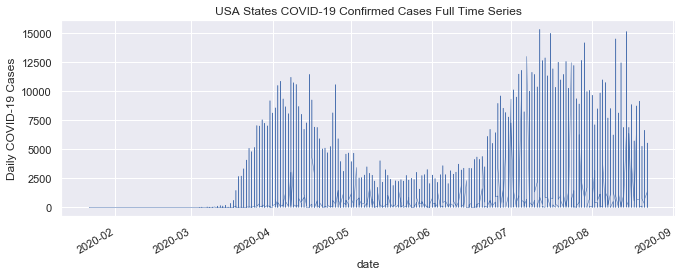

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
# create a line plot of the full time series of US’s daily confirmed cases of Covid19  for Jan 22 - August 22, 2020.
state_df['confirmed_cases'].plot(linewidth=0.5)
plt.title('USA States COVID-19 Confirmed Cases Full Time Series')
plt.ylabel('Daily COVID-19 Cases')

The plot above shows the full time series of US states COVID-19 daily confirmed cases. It exhibits seasonality in time series analysis. Moreover, the number of cases are especially high between months of April and May, and increasing again at the start of July. However, the line plot is crowded due to many data points. Let’s plot the data as dots instead, and also look at the some States time series.

In [27]:
state_df_initial = dly_confirmed_state_TS.copy()
state_df_initial = state_df_initial.set_index('date')

state_df_initial.head()

,USA_Alabama,USA_Alaska,USA_Arizona,USA_Arkansas,USA_California,USA_Colorado,USA_Connecticut,USA_Delaware,USA_District of Columbia,USA_Florida,...,USA_Texas,USA_Utah,USA_Vermont,USA_Virginia,USA_Washington,USA_West Virginia,USA_Wisconsin,USA_Wyoming,month,day
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,22
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,23
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,24
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,25
2020-01-26,0,0,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,26


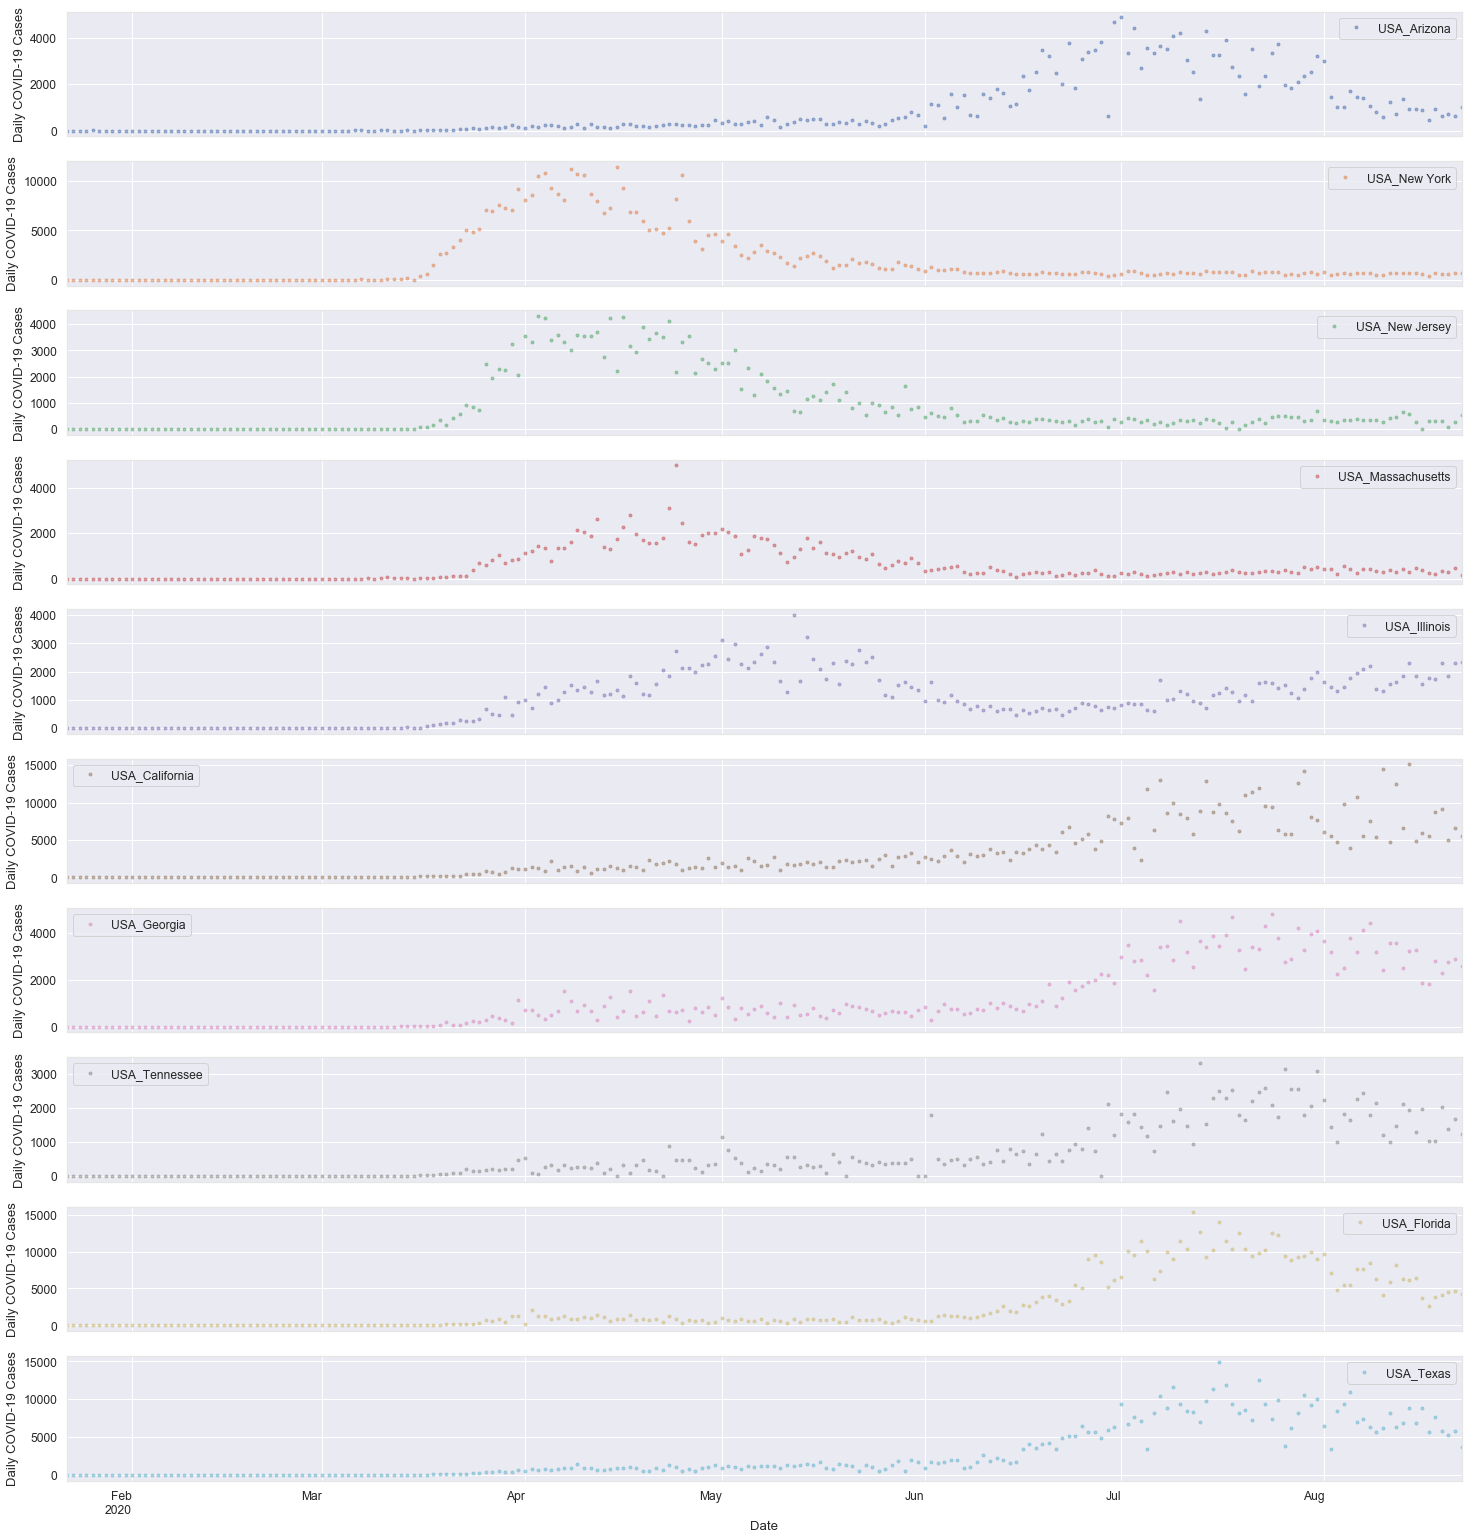

In [28]:
sns.set(font_scale=1.1) 
sns.set_style('darkgrid',{'axes.edgecolor': '.9'},)
plt.rcParams['patch.force_edgecolor'] = True
cols_plot = ['USA_Arizona', 'USA_New York', 'USA_New Jersey', 'USA_Massachusetts', 'USA_Illinois', 'USA_California', 
             'USA_Georgia', 'USA_Tennessee', 'USA_Florida', 'USA_Texas']
             #'USA_Pennsylvania', 'USA_Michigan', 'USA_Florida', 'USA_Texas', 'USA_Connecticut']
axes = state_df_initial[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', 
            figsize=(25, 30), subplots=True)
plt.xticks(rotation = 0)
for ax in axes:
    ax.set_ylabel('Daily COVID-19 Cases')
    ax.set_xlabel('Date')

From the selected States above, Arizona, Florida, Texas, California are the states that started to increase in July. Moreover, it shows that New York, New Jersey, Massachusetts, Illinois are states that significantly contributed to the peak of cases during April.

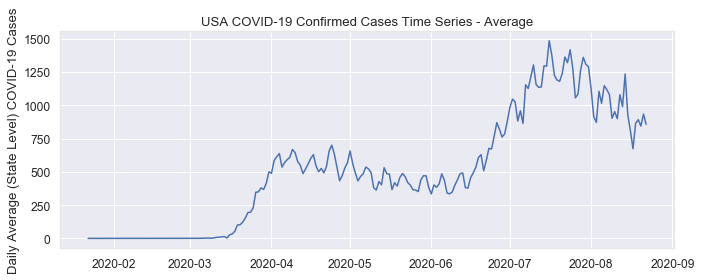

In [29]:
# To get the time series - average, I group them by date and compute for the average of daily confirmed cases frequencies
mean_group = state_df[['state','confirmed_cases']].groupby(['date'])['confirmed_cases'].mean()
plt.plot(mean_group)
plt.title('USA COVID-19 Confirmed Cases Time Series - Average')
plt.ylabel('Daily Average (State Level) COVID-19 Cases')
plt.show()

Averagely, the plot shows that the daily confirmed cases were doubled starting late June while tripled after first week of July compared to previous month. Let's investigate further by zooming in starting last week of March until first week of May. 

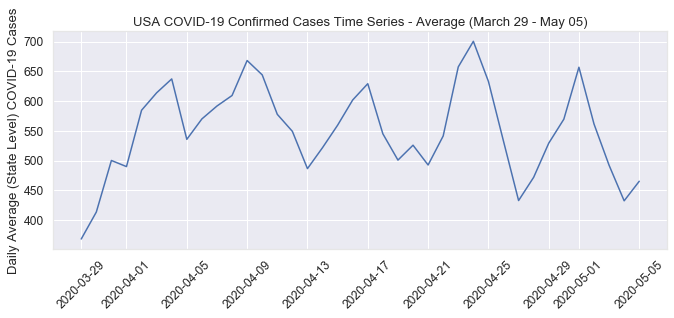

In [30]:
mean_group = state_df.loc['2020-03-29': '2020-05-05'][['state','confirmed_cases']].groupby(['date'])['confirmed_cases'].mean()
plt.plot(mean_group)
plt.title('USA COVID-19 Confirmed Cases Time Series - Average (March 29 - May 05)')
plt.ylabel('Daily Average (State Level) COVID-19 Cases')
plt.xticks(rotation = 45)
plt.show()

The plot shows the number of new daily average confirmed cases by daily date. This shows weekly fluctuations of cases beginning March 30 until end of April. It demonstrates a weekly pattern of lowest number of daily average confirmed cases on March 29 (Sunday), April 5 (Sunday), 13 (Monday), 21 (Tuesday), 27 (Monday), May 4 (Monday) while highest number of daily confirmed cases on April 4 (Saturday), 9 (Thursday), 17 (Friday), 24 (Friday), May 01 (Friday).

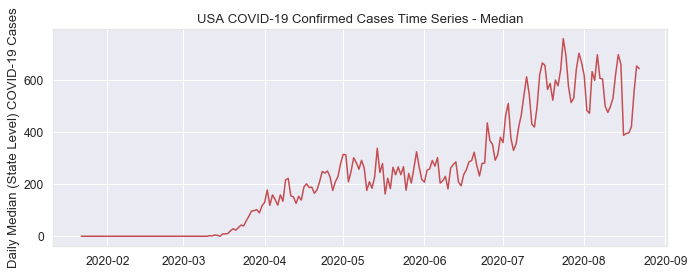

In [31]:
# To get the time series - median, I group them by date and compute for the median of daily confirmed cases frequencies
median_group = state_df[['state','confirmed_cases']].groupby(['date'])['confirmed_cases'].median()
plt.plot(median_group, color = 'r')
plt.title('USA COVID-19 Confirmed Cases Time Series - Median')
plt.ylabel('Daily Median (State Level) COVID-19 Cases')
plt.show()

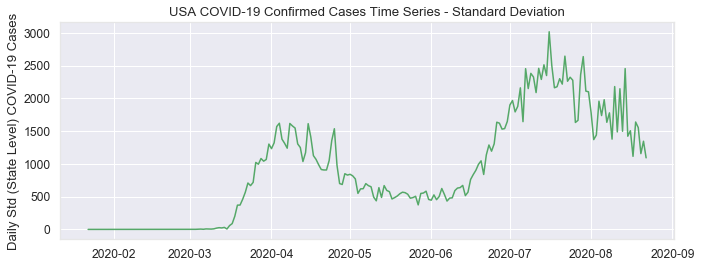

In [32]:
# To get the time series - Std or standard deviation, I group them by date and compute for the standard deviation of daily confirmed cases frequencies
std_group = state_df[['state','confirmed_cases']].groupby(['date'])['confirmed_cases'].std()
plt.plot(std_group, color = 'g')
plt.title('USA COVID-19 Confirmed Cases Time Series - Standard Deviation')
plt.ylabel('Daily Std (State Level) COVID-19 Cases')
plt.show()

In [33]:
# I need this replace function for visualization using heatmap
state_df['month_num'] = state_df['month']
state_df['month'].replace(12, '12 - December', inplace=True)
state_df['month'].replace(11, '11 - November', inplace=True)
state_df['month'].replace(10, '10 - October', inplace=True)
state_df['month'].replace(9, '09 - September', inplace=True)
state_df['month'].replace(8, '08 - August', inplace=True)
state_df['month'].replace(7, '07 - July', inplace=True)
state_df['month'].replace(6, '06 - June', inplace=True)
state_df['month'].replace(5, '05 - May', inplace=True)
state_df['month'].replace(4, '04 - April', inplace=True)
state_df['month'].replace(3, '03 - March', inplace=True)
state_df['month'].replace(2, '02 - February', inplace=True)
state_df['month'].replace(1, '01 - January', inplace=True)
state_df.head()

,state,month,day,confirmed_cases,mean,median,month_num
date,,,,,,,
2020-01-22,USA_Alabama,01 - January,22,0,535.196262,273.5,1
2020-01-23,USA_Alabama,01 - January,23,0,535.196262,273.5,1
2020-01-24,USA_Alabama,01 - January,24,0,535.196262,273.5,1
2020-01-25,USA_Alabama,01 - January,25,0,535.196262,273.5,1
2020-01-26,USA_Alabama,01 - January,26,0,535.196262,273.5,1


In [34]:
# Aside from what is the average of daily confirmed COVID-19 cases, I wanted to see what particular day for a particular month 
# has the highest daily daily confirmed cases. This is done by utilizing pivot funtion and heat map for visualization.
train_group = state_df.groupby(['day', 'month'])['confirmed_cases'].mean().reset_index()
train_group = train_group.pivot('month', 'day', 'confirmed_cases')
train_group.sort_index(inplace=True)
train_group

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
month,,,,,,,,,,,,,,,,,,,,,
01 - January,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.019231,0.019231,0.019231,0.000000,0.057692,0.000000,0.000000,0.000000,0.000000,0.038462
02 - February,0.019231,0.000000,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.153846,NaN,NaN
03 - March,0.115385,0.442308,0.384615,0.596154,1.346154,0.923077,2.211538,2.192308,1.307692,3.692308,...,152.250000,194.000000,197.096154,229.576923,346.692308,349.557692,379.057692,367.961538,413.326923,500.076923
04 - April,489.788462,584.615385,613.961538,637.307692,535.634615,570.000000,591.711538,609.403846,668.250000,644.115385,...,541.326923,657.538462,700.557692,633.076923,532.442308,432.673077,471.826923,529.230769,569.538462,NaN
05 - May,656.961538,561.500000,492.057692,432.211538,465.115385,485.673077,536.192308,522.576923,494.846154,381.038462,...,464.346154,419.673077,400.230769,365.211538,363.788462,351.807692,438.730769,471.211538,470.192308,382.884615
06 - June,333.673077,401.807692,383.750000,410.500000,485.076923,437.173077,340.961538,334.884615,348.538462,399.865385,...,587.230769,676.673077,671.807692,766.615385,869.961538,821.250000,761.634615,784.576923,879.653846,NaN
07 - July,983.750000,1047.019231,1025.115385,882.057692,959.288462,864.057692,1154.134615,1126.750000,1215.826923,1303.480769,...,1363.153846,1320.615385,1417.288462,1278.153846,1056.788462,1084.423077,1266.461538,1360.788462,1308.288462,1289.826923
08 - August,1124.384615,914.750000,871.961538,1105.807692,1015.076923,1147.250000,1118.307692,1080.134615,902.461538,952.384615,...,857.153846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
train_group.isnull().sum()

day
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    0
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    2
31    4
dtype: int64

Four total missing values from day 31, one missing value from days day 30, and one total missing value for the remaining days except day 22.

In [36]:
# checking for any null value from any column 
train_group[train_group.isnull().any(axis=1)]

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
month,,,,,,,,,,,,,,,,,,,,,
01 - January,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.019231,0.019231,0.019231,0.000000,0.057692,0.000000,0.000000,0.000000,0.000000,0.038462
02 - February,0.019231,0.000000,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.153846,NaN,NaN
04 - April,489.788462,584.615385,613.961538,637.307692,535.634615,570.000000,591.711538,609.403846,668.250000,644.115385,...,541.326923,657.538462,700.557692,633.076923,532.442308,432.673077,471.826923,529.230769,569.538462,NaN
06 - June,333.673077,401.807692,383.750000,410.500000,485.076923,437.173077,340.961538,334.884615,348.538462,399.865385,...,587.230769,676.673077,671.807692,766.615385,869.961538,821.250000,761.634615,784.576923,879.653846,NaN
08 - August,1124.384615,914.750000,871.961538,1105.807692,1015.076923,1147.250000,1118.307692,1080.134615,902.461538,952.384615,...,857.153846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 These missing values should be imputed with zeroes using fillna() to visualize the heatmap better. 

In [37]:
train_group.fillna(value=0, inplace=True)
# recheck for any null value from any column after imputation
train_group[train_group.isnull().any(axis=1)]

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
month,,,,,,,,,,,,,,,,,,,,,


In [38]:
train_group.isnull().sum()

day
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
dtype: int64

In [39]:
train_group
#train_group[[13,14,15,16,17,18,19,20,21,22,23,24,25]]

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
month,,,,,,,,,,,,,,,,,,,,,
01 - January,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.019231,0.019231,0.019231,0.000000,0.057692,0.000000,0.000000,0.000000,0.000000,0.038462
02 - February,0.019231,0.000000,0.057692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.153846,0.000000,0.000000
03 - March,0.115385,0.442308,0.384615,0.596154,1.346154,0.923077,2.211538,2.192308,1.307692,3.692308,...,152.250000,194.000000,197.096154,229.576923,346.692308,349.557692,379.057692,367.961538,413.326923,500.076923
04 - April,489.788462,584.615385,613.961538,637.307692,535.634615,570.000000,591.711538,609.403846,668.250000,644.115385,...,541.326923,657.538462,700.557692,633.076923,532.442308,432.673077,471.826923,529.230769,569.538462,0.000000
05 - May,656.961538,561.500000,492.057692,432.211538,465.115385,485.673077,536.192308,522.576923,494.846154,381.038462,...,464.346154,419.673077,400.230769,365.211538,363.788462,351.807692,438.730769,471.211538,470.192308,382.884615
06 - June,333.673077,401.807692,383.750000,410.500000,485.076923,437.173077,340.961538,334.884615,348.538462,399.865385,...,587.230769,676.673077,671.807692,766.615385,869.961538,821.250000,761.634615,784.576923,879.653846,0.000000
07 - July,983.750000,1047.019231,1025.115385,882.057692,959.288462,864.057692,1154.134615,1126.750000,1215.826923,1303.480769,...,1363.153846,1320.615385,1417.288462,1278.153846,1056.788462,1084.423077,1266.461538,1360.788462,1308.288462,1289.826923
08 - August,1124.384615,914.750000,871.961538,1105.807692,1015.076923,1147.250000,1118.307692,1080.134615,902.461538,952.384615,...,857.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


The plot (Time series - average) above that shows that the daily confirmed cases were doubled in June and tripled in July is verified from the dataframe above. Numerically, it is shown that the cases were doubled starting June 25 and tripled starting July 7 compared to their previous months.  

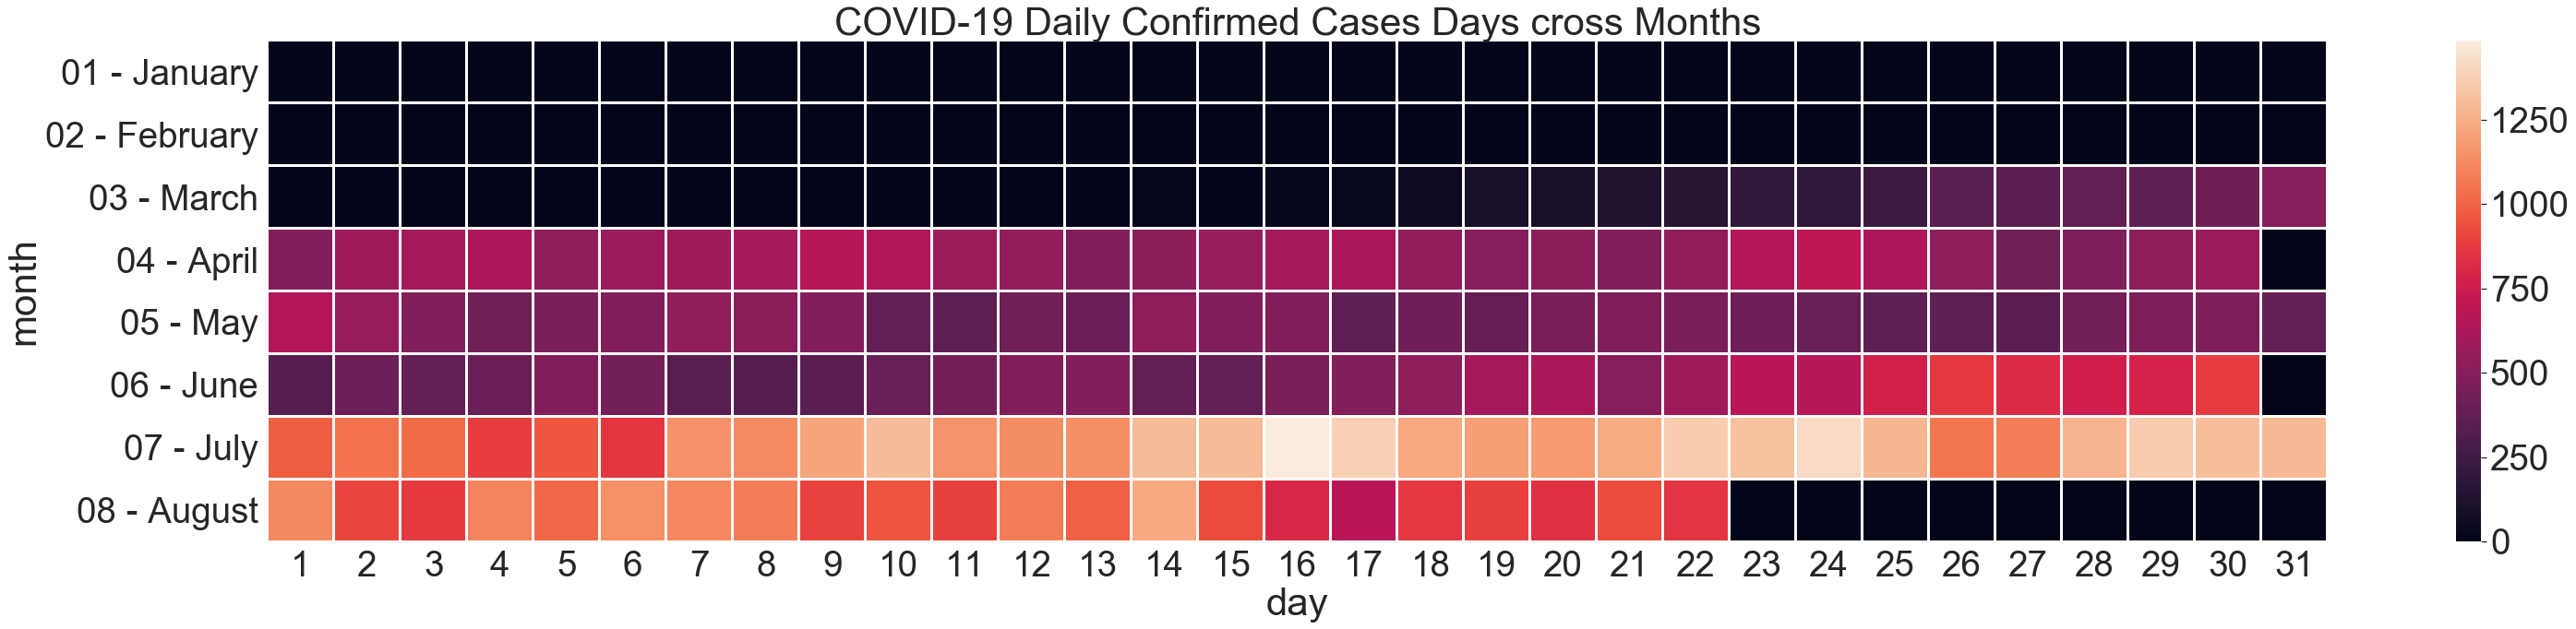

In [40]:
# HEATMAP - to give us a clear picture of when the outbreaks occur. 
sns.set(font_scale = 3.5)
f,ax = plt.subplots(figsize=(50,10))
sns.heatmap(train_group, annot=False, ax=ax, fmt='d', linewidths=2)
plt.title('COVID-19 Daily Confirmed Cases Days cross Months')
plt.show()

The plot above shows and confirms that daily COVID-19 cases had an earlier peak during month of April and had been on a downward trajectory for months of May and early June. However, the resurgence can be seen starting June 25 when the cases is doubled compared to the same dates of May. Alarmingly, the daily cases resurgence continued and spiked starting July 7 when the cases has tripled compare to the month of June. Interestingly, this resurgence of new daily confirmed cases occurred after some US states began to ease the lockdown restrictions. 

### EDA SUMMARY

The researcher can already see some interesting patterns and insights emerged from the EDA:

- US States New York, New Jersey, Massachusetts, Illinois are states that significantly contributed to the peak of cases during April while Arizona, Florida, Texas, California daily confirmed cases surge in July.

- There is a trend of daily COVID-19 cases in April that shows weekly fluctuations. Interestingly, the weekly cycle begins with Sunday, Monday or Tuesday having the lowest daily average confirmed cases while ends on Thursday, Friday, Saturday having the highest daily average confirmed cases. The average confirmed cases increases each day and peaks on weekend then starts to plummet on Sunday. 

- The US daily COVID-19 cases was highest in month of April and slide afterwards. However, US is experiencing resurgence of daily COVID-19 cases in June when its cases has been doubled since June 25. This is maybe due to lockdown easing to which a lot of states began easing its stay-at-home order and other restrictions starting last week of May. This allowed operations of restaurants, bars, retail businesses, churches, gyms and salons and other public places.


### PLAN FOR IMPLEMENTATION

The researcher infers from the EDA that there is weekly fluctuations of COVID-19 daily confirmed cases. Also, the incubation period for COVID-19 can be up to 14 days which implies that one will develop symptoms within two weeks of active monitoring [5]. Consequently, the researcher will consider features engineering tasks. These tasks include but are not limited to creating new features such as 14-day change, 7-day change, 3-day change, and 1-day change. In addition, the following preprocessing methods will be done:
- Data Merging (Population, Kalman Filtering)
- Feature Selection (thru Pearson Correlation)
- Data Transformation (Log, Polynomial)
- Categorical Encoding (Label Encoding, One Hot Encoding)

Furthermore, the researcher will explore the following Machine Learning models on top of a classic estimator Kalman Filter for projecting the daily COVID-19 cases in US States. These algorithms have promising performance in predicting future events and have greater prediction accuracy.

- Multivariate Linear Regressor
- Random-forest Regressor
- Gradient Boosting Regressor
- XGBoost Regressor

Then, a comparative study of modeling daily cases with variation of parameters will be conducted. For optimization, the GridSearchCV will be utilized to tune the hyperparameters and cross-validate. The R-squared, root mean square errors (RMSE) and mean absolute errors (MAE) will be used as evaluation criteria for the train and test set. The implementation will be encapsulated together via Pipeline constructor from Sklearn. One of the future works, therefore, would be to provide a kernel of the work in Kaggle, an online community of data scientists. Hopefully, this may bring awareness to the resurgence of COVID-19 outbreak in US. The techniques utilized here may be implemented for a different kind of dataset (e.g. Philippines) that is still related to outbreak analytics.

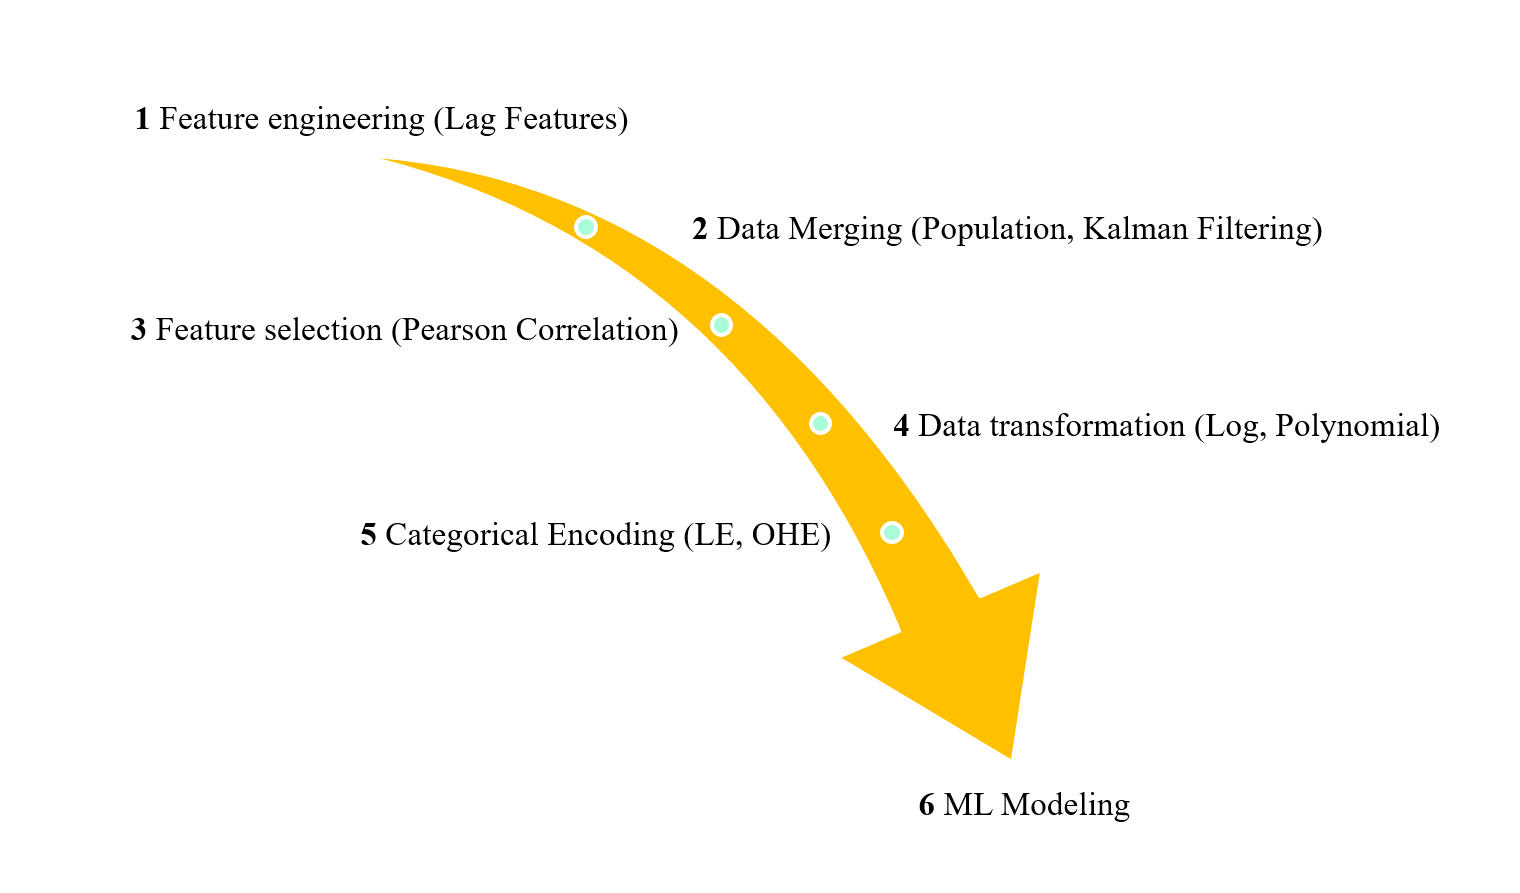

In [5]:
from IPython.display import Image
Image(filename='preprocessing.png')

### PRE-PROCESSING

In [42]:
# Defined the following functions to be used 
from pykalman import KalmanFilter
from plotly.offline import plot
sns.set(rc={'figure.figsize':(11, 4)})

# define the following list to explore the time series for this states that has significant contributions to the peak in April
# and resurgence in July
region_surge=['date','USA_New York','USA_New Jersey','USA_Massachusetts','USA_Illinois']
region_resurge=['date', 'USA_Florida','USA_Texas', 'USA_California', 'USA_Arizona', 'USA_Georgia', 'USA_Tennessee']

# This function will be called by function create_features to iteratively regress and complete creating new lag features such as
# last_day, 1_day_change, 3_day_change, 7_day_change, 14_day_change  
def iterative_regressor(df):
    t_iter=df.set_index(['date'])
    t_iter=t_iter.stack().reset_index(name='confirmed')
    t_iter.columns=['date', 'Region','confirmed']
    t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
    t_iter=t_iter.sort_values(['Region', 'date'])
    t_iter=t_iter.reset_index(drop=True)
        
    t_iter['last_day']=t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['14_day_change']=0
    for i in range(1,len(t_iter)):
        if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
            t_iter.iloc[i,3]=t_iter.iloc[i-1,2]
            t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
            t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
            t_iter.iloc[i,6]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2] 
        if(t_iter.iloc[i,1] is t_iter.iloc[i-15,1]):
            t_iter.iloc[i,7]=t_iter.iloc[i-1,2]-t_iter.iloc[i-15,2]

    t_iter=t_iter.fillna(0)  
    t_iter=t_iter.replace([np.inf, -np.inf], 0)
    return t_iter

# This function will be called to create new lag features 
def create_features(confirmed):  
    all_new=dly_confirmed_state_TS.copy()
    all_new['date']=pd.to_datetime(all_new['date']) 

    t_iter_out = iterative_regressor(all_new)
    test_iter=t_iter_out.merge(confirmed[['Region','Population']],how='left',on='Region')
    test_iter['Population']=test_iter['Population'].fillna(1)
    test_iter['Population']=test_iter['Population'].astype('int32')
    test_iter['Infection_rate'] =test_iter['confirmed']/test_iter['Population']*100000
    test_iter=test_iter.dropna()
    test_iter=test_iter.sort_values(['Region', 'date'])
    return test_iter

# The following functions are defined for kalman filtering to plot and subplots the smoothen time series data
def kalman_smooth(observations,damping=1):
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state

def kalman_plot(region):
    p_kalman=dly_confirmed_state_TS[region]
    p_kalman=p_kalman.set_index(['date'])
    p_kalman.iloc[:,:].plot(figsize=(14,8)).set_title('COVID-19 Daily Confirmed Cases',y=1.03,size=17)

    plt.figure(figsize=(14,8))
    for column in p_kalman:
        smoothed = kalman_smooth(p_kalman[column].values)
        p_kalman[column + ' Kalman'] = list(map(int, smoothed)) 
        plt.plot(smoothed, label=column)
        plt.plot(p_kalman[column].values,linestyle='--',color='grey',linewidth=0.5)
    plt.legend()
    plt.suptitle('Smoothed Trend overlaid on COVID-19 daily new confirmed cases using Kalman Filtering',y=0.95,size=17)
    return p_kalman
    
def kalman_subplot(region, row, col):
    p_kalman=dly_confirmed_state_TS[region]
    p_kalman=p_kalman.set_index(['date'])
    fig, ax = plt.subplots(row, col, figsize=(15,12))
    i=0
    for column in p_kalman:
        smoothed = kalman_smooth(p_kalman[column].values)
        ax[i//2,i%2].plot(smoothed)
        ax[i//2,i%2].plot(p_kalman[column].values,linestyle='--',color='grey',linewidth=0.5)
        ax[i//2,i%2].title.set_text(column)
        i=i+1
    plt.suptitle('Smoothed Trend overlaid on COVID-19 daily new confirmed cases for each State using Kalman Filtering',y=1.03,size=17)
    plt.tight_layout()

#### KALMAN FILTERING

In [43]:
# reading the pivoted dataframe (State's time series data for each column) that I saved as csv during EDA  
dly_confirmed_state_TS = pd.read_csv('dly_confirmed_state.csv')
dly_confirmed_state_TS

,date,USA_Alabama,USA_Alaska,USA_Arizona,USA_Arkansas,USA_California,USA_Colorado,USA_Connecticut,USA_Delaware,USA_District of Columbia,...,USA_South Dakota,USA_Tennessee,USA_Texas,USA_Utah,USA_Vermont,USA_Virginia,USA_Washington,USA_West Virginia,USA_Wisconsin,USA_Wyoming
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2020-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-26,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2020-08-18,1357,62,915,410,8725,261,0,57,52,...,81,1026,7702,263,3,861,542,97,0,29
210,2020-08-19,1117,67,637,729,9134,270,59,50,29,...,125,2030,5821,364,3,737,426,69,1297,71
211,2020-08-20,971,82,723,549,4993,329,118,75,55,...,125,1375,5259,461,4,860,700,180,740,26
212,2020-08-21,1183,68,619,887,6633,0,87,52,60,...,193,1669,5740,463,4,978,390,90,826,67


In [44]:
dly_confirmed_state_TS.columns

Index(['date', 'USA_Alabama', 'USA_Alaska', 'USA_Arizona', 'USA_Arkansas',
       'USA_California', 'USA_Colorado', 'USA_Connecticut', 'USA_Delaware',
       'USA_District of Columbia', 'USA_Florida', 'USA_Georgia', 'USA_Hawaii',
       'USA_Idaho', 'USA_Illinois', 'USA_Indiana', 'USA_Iowa', 'USA_Kansas',
       'USA_Kentucky', 'USA_Louisiana', 'USA_Maine', 'USA_Maryland',
       'USA_Massachusetts', 'USA_Michigan', 'USA_Minnesota', 'USA_Mississippi',
       'USA_Missouri', 'USA_Montana', 'USA_Nebraska', 'USA_Nevada',
       'USA_New Hampshire', 'USA_New Jersey', 'USA_New Mexico', 'USA_New York',
       'USA_North Carolina', 'USA_North Dakota', 'USA_Ohio', 'USA_Oklahoma',
       'USA_Oregon', 'USA_Pennsylvania', 'USA_Puerto Rico', 'USA_Rhode Island',
       'USA_South Carolina', 'USA_South Dakota', 'USA_Tennessee', 'USA_Texas',
       'USA_Utah', 'USA_Vermont', 'USA_Virginia', 'USA_Washington',
       'USA_West Virginia', 'USA_Wisconsin', 'USA_Wyoming'],
      dtype='object')

,USA_New York,USA_New Jersey,USA_Massachusetts,USA_Illinois,USA_New York Kalman,USA_New Jersey Kalman,USA_Massachusetts Kalman,USA_Illinois Kalman
date,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,1,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2020-08-18,655,331,222,1739,626,313,320,1925
2020-08-19,631,329,352,2296,630,310,322,1986
2020-08-20,601,100,313,1832,634,305,322,2017


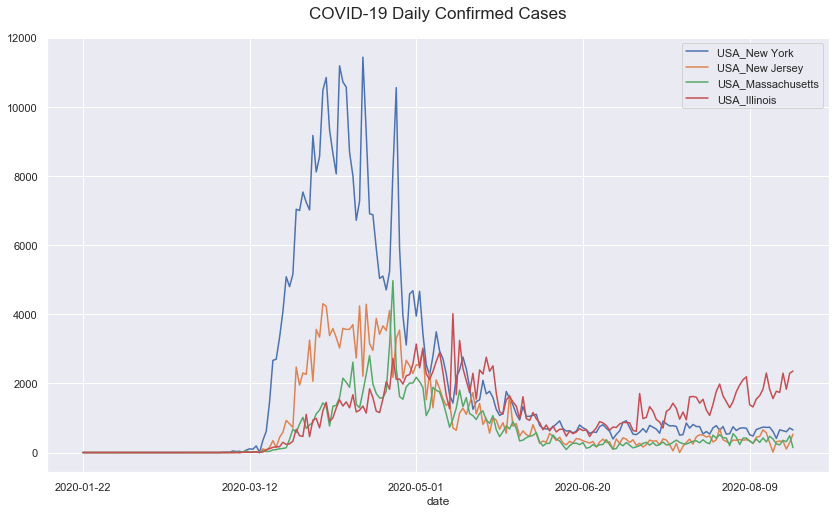

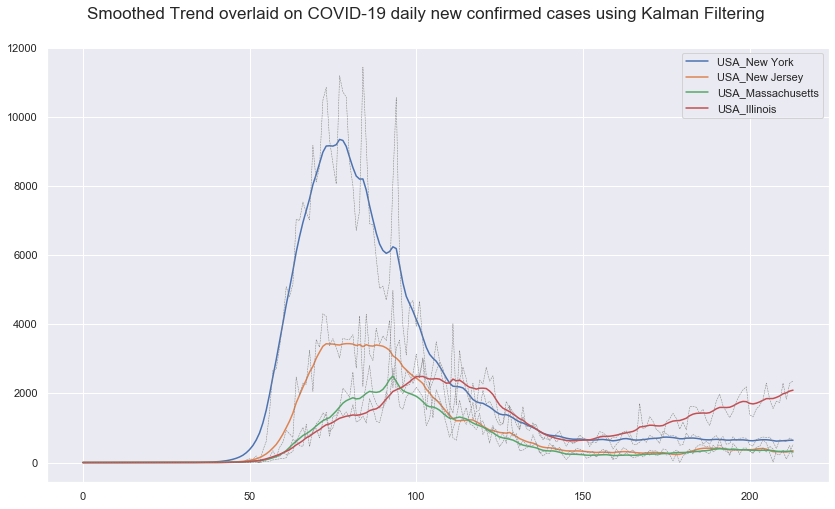

In [46]:
# Plot the Kalman filter for states that significantly contributed to the peak in April
kalman_plot(region_surge)

,USA_Florida,USA_Texas,USA_California,USA_Arizona,USA_Georgia,USA_Tennessee,USA_Florida Kalman,USA_Texas Kalman,USA_California Kalman,USA_Arizona Kalman,USA_Georgia Kalman,USA_Tennessee Kalman
date,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,2,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-18,3838,7702,8725,915,2816,1026,4526,6509,7351,810,2624,1488
2020-08-19,4115,5821,9134,637,2305,2030,4494,6212,7224,790,2620,1520
2020-08-20,4555,5259,4993,723,2759,1375,4501,5953,6905,786,2647,1502


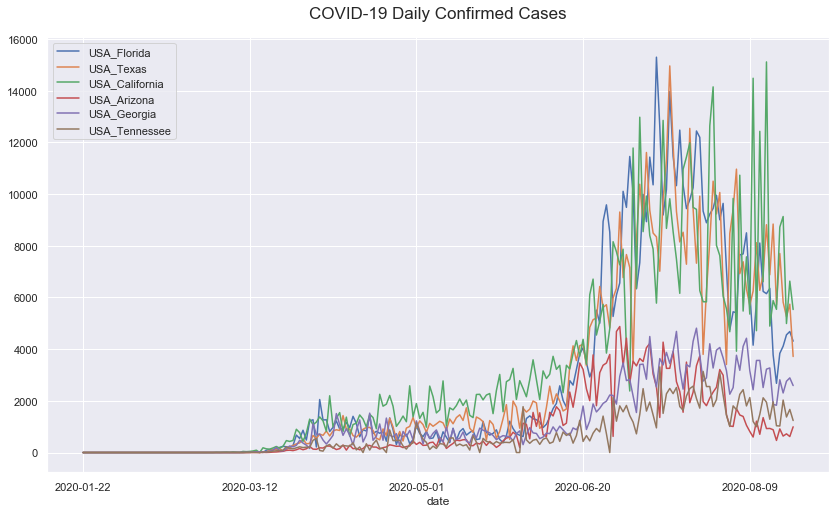

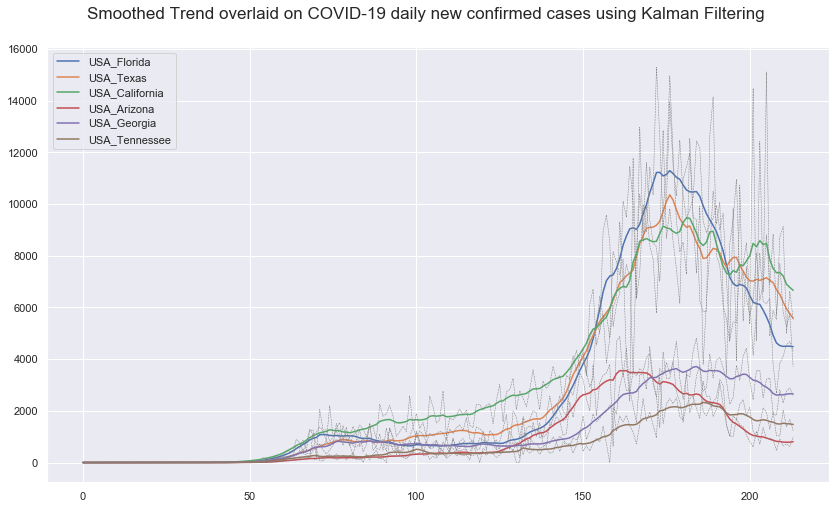

In [47]:
# Plot the Kalman filter for states that significantly contributed to the resurgence in July
kalman_plot(region_resurge)

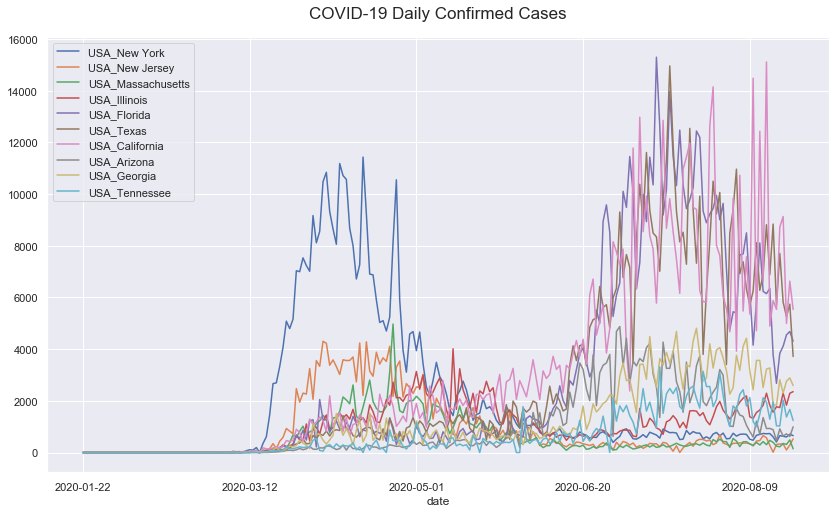

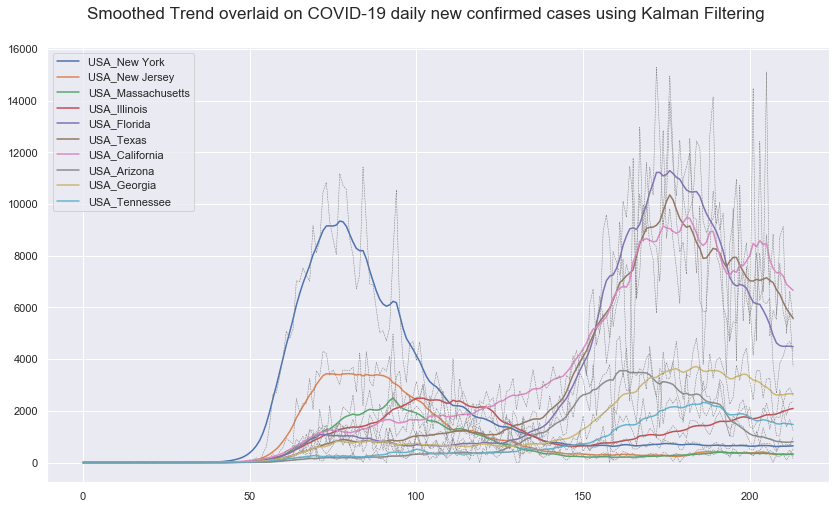

In [48]:
# Combine and plot the Kalman filter for states that significantly contributed to the surge in April and July
region = region_surge + region_resurge[1:]
p_kalman = kalman_plot(region)

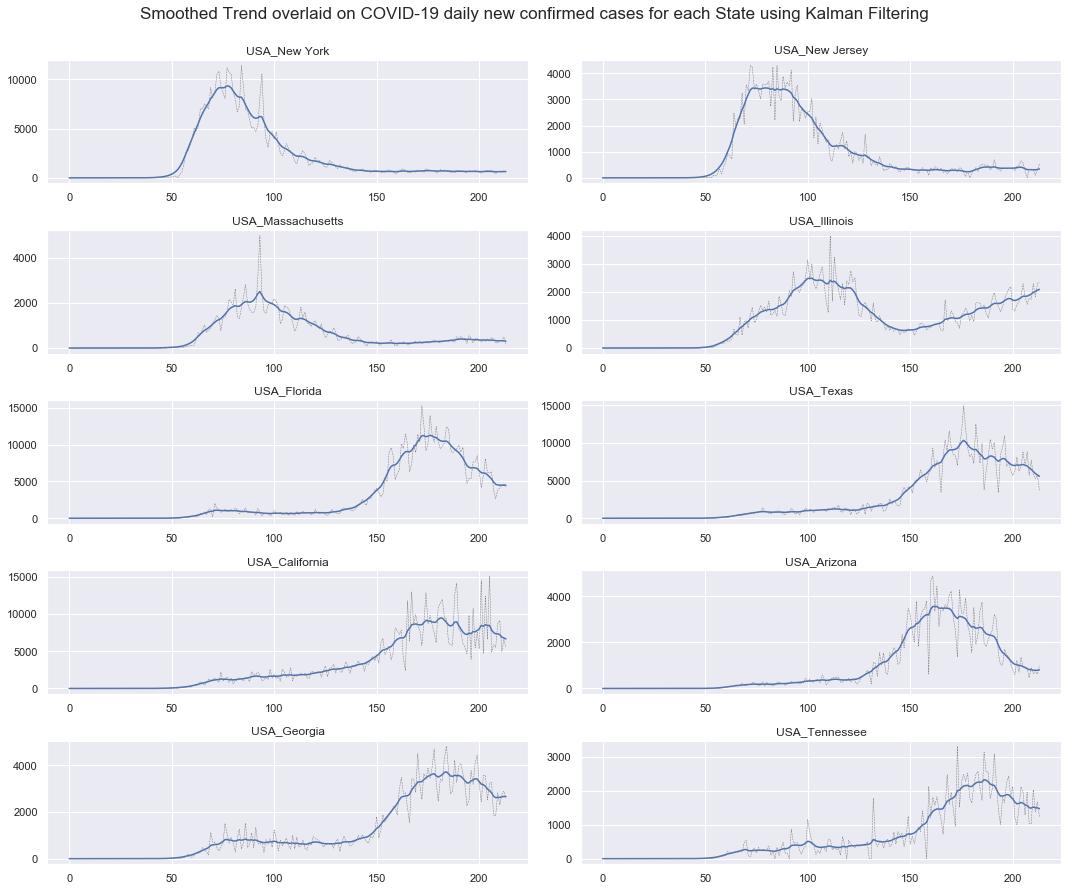

In [49]:
# Subplots to see the individual Kalman filter data for each state that signficantly contributed to the surge in April and July
kalman_subplot(region, 5, 2)

,USA_Alabama,USA_Alaska,USA_Arizona,USA_Arkansas,USA_California,USA_Colorado,USA_Connecticut,USA_Delaware,USA_District of Columbia,USA_Florida,...,USA_South Dakota Kalman,USA_Tennessee Kalman,USA_Texas Kalman,USA_Utah Kalman,USA_Vermont Kalman,USA_Virginia Kalman,USA_Washington Kalman,USA_West Virginia Kalman,USA_Wisconsin Kalman,USA_Wyoming Kalman
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-18,1357,62,915,410,8725,261,0,57,52,3838,...,124,1488,6509,354,6,910,555,110,692,43
2020-08-19,1117,67,637,729,9134,270,59,50,29,4115,...,133,1520,6212,368,6,911,557,110,760,44
2020-08-20,971,82,723,549,4993,329,118,75,55,4555,...,144,1502,5953,381,6,929,573,114,774,42


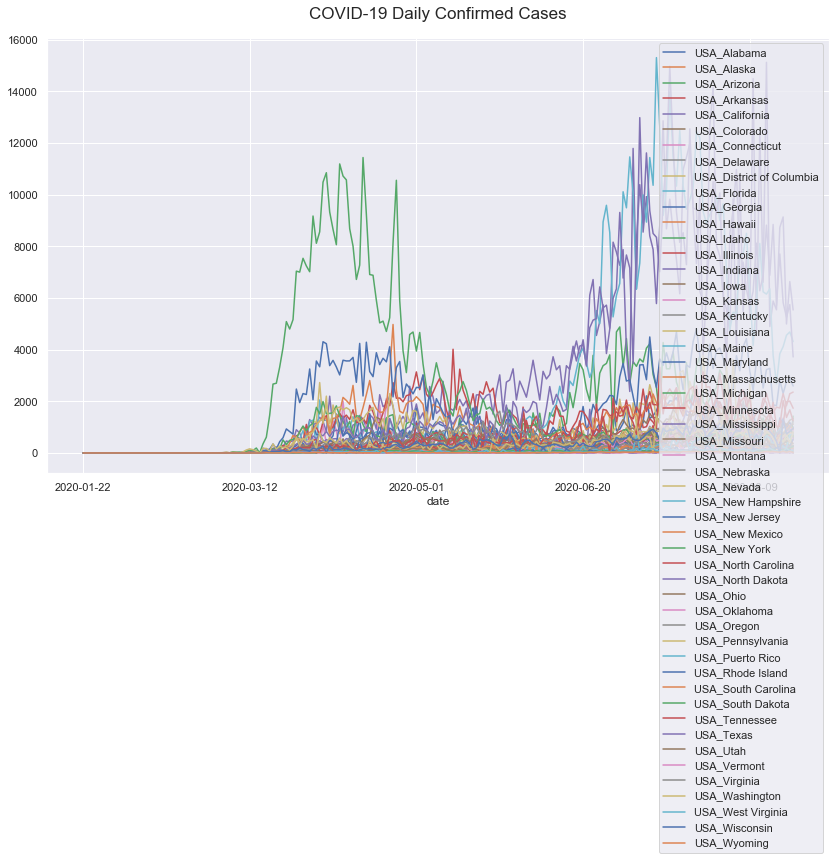

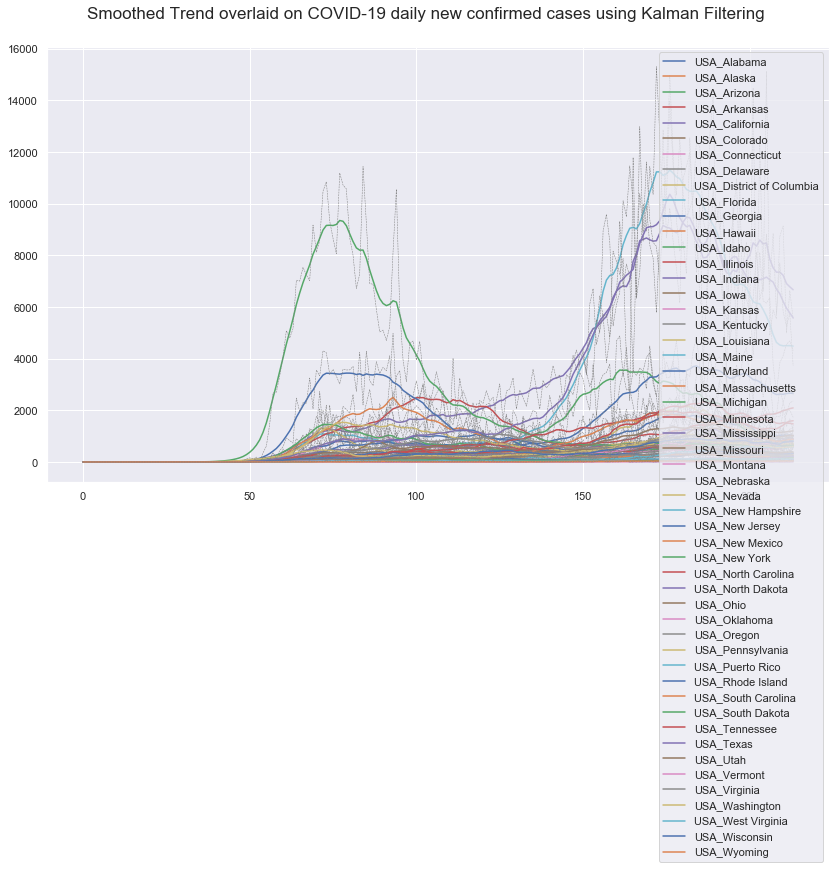

In [50]:
# To output and plot all the smoothen time series data for each of the 52 states
kalman_smooth_df = kalman_plot(list(dly_confirmed_state_TS.columns))
kalman_smooth_df

In [51]:
# Cleanup the data to drop the unsmoothen time series data and left with the kalman filter data for each state. This is to be used 
# for data merging later
kalman_smooth_df.drop(kalman_smooth_df.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,
                          31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1,inplace=True)
kalman_smooth_df.columns = list(dly_confirmed_state_TS.columns)[1:]
kalman_smooth_df

,USA_Alabama,USA_Alaska,USA_Arizona,USA_Arkansas,USA_California,USA_Colorado,USA_Connecticut,USA_Delaware,USA_District of Columbia,USA_Florida,...,USA_South Dakota,USA_Tennessee,USA_Texas,USA_Utah,USA_Vermont,USA_Virginia,USA_Washington,USA_West Virginia,USA_Wisconsin,USA_Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-18,1034,73,810,553,7351,299,86,81,55,4526,...,124,1488,6509,354,6,910,555,110,692,43
2020-08-19,1038,74,790,582,7224,299,82,76,54,4494,...,133,1520,6212,368,6,911,557,110,760,44
2020-08-20,1034,75,786,598,6905,303,80,73,55,4501,...,144,1502,5953,381,6,929,573,114,774,42


I could try to fit a model for each state. And while this can work well, I may have problems due to having only 214 (Jan 22 - August 22) data points for each model, which is really low. Instead, I concatenated all the series and train a single model with much more data as machine learning models tend to improve with more data. 

To do this I have to "melt" the data. This simply means transforming the data in a way that each line becomes: date, Region (States), confirmed. This resulted to 11,128 data points to train the model.

In [52]:
kalman_new=kalman_smooth_df.copy()
kalman_new=kalman_new.stack().reset_index(name='confirmed')
kalman_new.columns=['date', 'Region','confirmed']
kalman_new['date']=pd.to_datetime(kalman_new['date'], errors ='coerce')
kalman_new=kalman_new.sort_values(['Region', 'date'])
kalman_new=kalman_new.reset_index(drop=True)
kalman_new

,date,Region,confirmed
0,2020-01-22,USA_Alabama,0
1,2020-01-23,USA_Alabama,0
2,2020-01-24,USA_Alabama,0
3,2020-01-25,USA_Alabama,0
4,2020-01-26,USA_Alabama,0
...,...,...,...
11123,2020-08-18,USA_Wyoming,43
11124,2020-08-19,USA_Wyoming,44
11125,2020-08-20,USA_Wyoming,42
11126,2020-08-21,USA_Wyoming,43


#### FEATURE ENGINEERING - LAG FEATURES

In [53]:
# Used the defined function create_featues to populate the lag features, merge the population data, and computed infection_rate
test_state_iter = create_features(dly_confirmed_US_state)
test_state_iter.to_csv('confirmed_state_final.csv', index=False)
test_state_iter

,date,Region,confirmed,last_day,1_day_change,3_day_change,7_day_change,14_day_change,Population,Infection_rate
0,2020-01-22,USA_Alabama,0,0,0,0,0,0,4788653,0.000000
1,2020-01-23,USA_Alabama,0,0,0,0,0,0,4788653,0.000000
2,2020-01-24,USA_Alabama,0,0,0,0,0,0,4788653,0.000000
3,2020-01-25,USA_Alabama,0,0,0,0,0,0,4788653,0.000000
4,2020-01-26,USA_Alabama,0,0,0,0,0,0,4788653,0.000000
...,...,...,...,...,...,...,...,...,...,...
11123,2020-08-18,USA_Wyoming,29,45,-14,-19,45,5,575216,5.041584
11124,2020-08-19,USA_Wyoming,71,29,-16,-15,-2,-7,575216,12.343189
11125,2020-08-20,USA_Wyoming,26,71,42,12,58,32,575216,4.520041
11126,2020-08-21,USA_Wyoming,67,26,-45,-19,-7,-4,575216,11.647798


#### DATA MERGING - POPULATION, KALMAN

In [54]:
# Along with the added population column above, merge the created Kalman data to the dataframe
feat_df = pd.merge(test_state_iter,
                 kalman_new,
                 on = ['date', 'Region'])
feat_df.rename(columns = {'confirmed_x':'confirmed', 'confirmed_y':'Kalman'}, inplace = True)
feat_df

,date,Region,confirmed,last_day,1_day_change,3_day_change,7_day_change,14_day_change,Population,Infection_rate,Kalman
0,2020-01-22,USA_Alabama,0,0,0,0,0,0,4788653,0.000000,0
1,2020-01-23,USA_Alabama,0,0,0,0,0,0,4788653,0.000000,0
2,2020-01-24,USA_Alabama,0,0,0,0,0,0,4788653,0.000000,0
3,2020-01-25,USA_Alabama,0,0,0,0,0,0,4788653,0.000000,0
4,2020-01-26,USA_Alabama,0,0,0,0,0,0,4788653,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
11123,2020-08-18,USA_Wyoming,29,45,-14,-19,45,5,575216,5.041584,43
11124,2020-08-19,USA_Wyoming,71,29,-16,-15,-2,-7,575216,12.343189,44
11125,2020-08-20,USA_Wyoming,26,71,42,12,58,32,575216,4.520041,42
11126,2020-08-21,USA_Wyoming,67,26,-45,-19,-7,-4,575216,11.647798,43


#### FEATURE SELECTION - CORRELATION MATRIX

Correlation to Confirmed
confirmed         1.000000
last_day          0.931031
1_day_change      0.019941
3_day_change      0.068815
7_day_change      0.108122
14_day_change     0.262267
Population        0.518001
Infection_rate    0.653283
Kalman            0.970486
Name: confirmed, dtype: float64


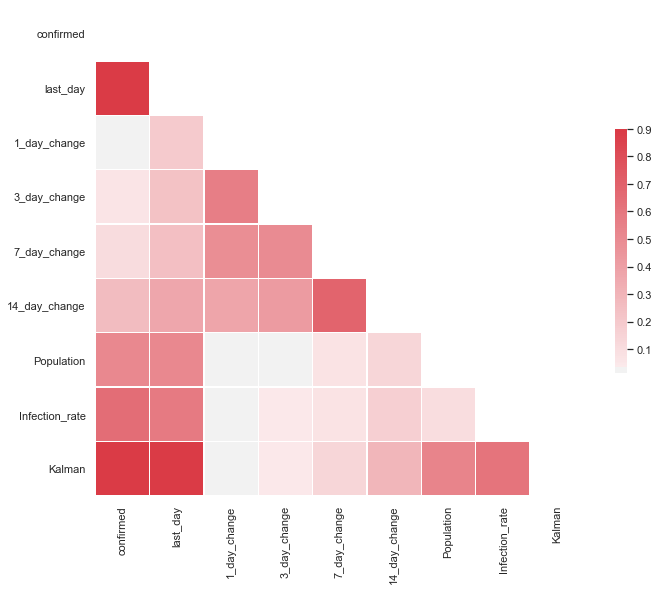

In [55]:
# Compute then plot the Correlation Matrix
sns.set(style="white")
corr = feat_df.iloc[:,2:].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print('Correlation to Confirmed')
print(corr.confirmed)

With the correlation result above, I picked variables last_day, kalman, and infection_rate for feature selection. Since infection_rate is daily confirmed cases per 100,000 people, I drop population to avoid multicollinearity issue with infection rate.

In [56]:
feat_df.drop(['1_day_change', '3_day_change', '7_day_change', '14_day_change', 'Population'], axis=1, inplace=True)
feat_df

,date,Region,confirmed,last_day,Infection_rate,Kalman
0,2020-01-22,USA_Alabama,0,0,0.000000,0
1,2020-01-23,USA_Alabama,0,0,0.000000,0
2,2020-01-24,USA_Alabama,0,0,0.000000,0
3,2020-01-25,USA_Alabama,0,0,0.000000,0
4,2020-01-26,USA_Alabama,0,0,0.000000,0
...,...,...,...,...,...,...
11123,2020-08-18,USA_Wyoming,29,45,5.041584,43
11124,2020-08-19,USA_Wyoming,71,29,12.343189,44
11125,2020-08-20,USA_Wyoming,26,71,4.520041,42
11126,2020-08-21,USA_Wyoming,67,26,11.647798,43


In [57]:
# checking for missing values
feat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128 entries, 0 to 11127
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            11128 non-null  datetime64[ns]
 1   Region          11128 non-null  object        
 2   confirmed       11128 non-null  int64         
 3   last_day        11128 non-null  int64         
 4   Infection_rate  11128 non-null  float64       
 5   Kalman          11128 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 608.6+ KB


Hence, there is no missing values and there is no need for imputation

In [58]:
# checking the general description of data to decide on feature scaling that needs to be done 
feat_df.describe()

,confirmed,last_day,Infection_rate,Kalman
count,11128.000000,11128.000000,11128.000000,11128.000000
mean,509.196531,505.191050,6.993796,508.781991
std,1261.846087,1259.928425,9.632810,1204.656941
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.010561,5.000000
50%,108.000000,104.000000,3.612806,120.000000
75%,509.000000,502.000000,9.584190,535.000000
max,15300.000000,15300.000000,85.199400,11297.000000


#### FEATURE SCALING - LOG SCALER

In the preprocessing pipeline below, I used feature scaling of log. Based on the general description of dataframe feat_df above, some of the features are skewed, around 2 or 3 orders of magnitude compare to other features (please see the general description of data below), and contain many outliers. With this data, either scaling using the mean and variance of the data through StandardScaler or scaling from range zero to one through MinMaxScaler is not appropriate. Logarithmic scaling is more appropriate to address the skewness of data.

#### CATEGORICAL ENCODING - LABEL ENCODING, ONE HOT ENCODING

Since some machine models can only understand the numbers, I need to convert columns date and Region (States) to numerical columns so that a machine learning algorithm understands it. I applied label encoding to column date since order is important. On the other hand, one hot encoding is applied to Region. As the Region contains 52 states, 52 new features will be added to the existing 6 columns of dataframe, thus increasing the sparsity of the data. These encodings will be implemented within the preprocessing pipeline using Sklearns's ColumnTransformer and Pipeline in the next section. 

### MACHINE LEARNING MODELING 

Introduction of the models:
   
    This comparative study has the intent of uncovering the gaps related to different regression models such as linear regressor, random forest, gradient boosting, and XGBoost. Linear regressor is the most simple regression model in supervised machine learning. And in any comparative study, it is always better to start with simple model before proceeding to the complex models such as boosting family models. In this study, the effect of polynomial features with degree two to the performance of linear regressor model has been explored. For ensemble methods, the researcher chose the bagging technique RandomForest regressor and boosting techniques such as Gradient Boosting and XGBoost algorithms. The researcher would like to identify the performance difference between algorithms that do parallel training (RandomForet) or sequential training (Gradient Boost, XGBoost). Among the boosting techniques, XGBoost is always the first algorithm of choice in any data science and machine learning hackaton. Including this model in this comparative study will give the researcher a confirmation or nullification of its powerful and robust characteristic.

In [59]:
# import libraries
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, FunctionTransformer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from xgboost import XGBRegressor
import time

In [60]:
# Categorical encoding - Label encoding 
# This is done for date variable in order to convert date into integer and use in recursive forecasting as iterator
le = LabelEncoder()
feat_df['date'] = le.fit_transform(feat_df['date']) 
feat_df

,date,Region,confirmed,last_day,Infection_rate,Kalman
0,0,USA_Alabama,0,0,0.000000,0
1,1,USA_Alabama,0,0,0.000000,0
2,2,USA_Alabama,0,0,0.000000,0
3,3,USA_Alabama,0,0,0.000000,0
4,4,USA_Alabama,0,0,0.000000,0
...,...,...,...,...,...,...
11123,209,USA_Wyoming,29,45,5.041584,43
11124,210,USA_Wyoming,71,29,12.343189,44
11125,211,USA_Wyoming,26,71,4.520041,42
11126,212,USA_Wyoming,67,26,11.647798,43


#### RECURSIVE FORECASTING APPROACH

This approach of forecasting is accomplished by feeding in the prediction of the model as a new input to the training set. Then, using the new training set to predict tomorrow confirmed cases. In this case, I opted to iterate recursively 1-day-ahead forward until all the the validation set is completed as shown in the diagram below. This type of forecasting is very unconventional to machine learning viewpoint.

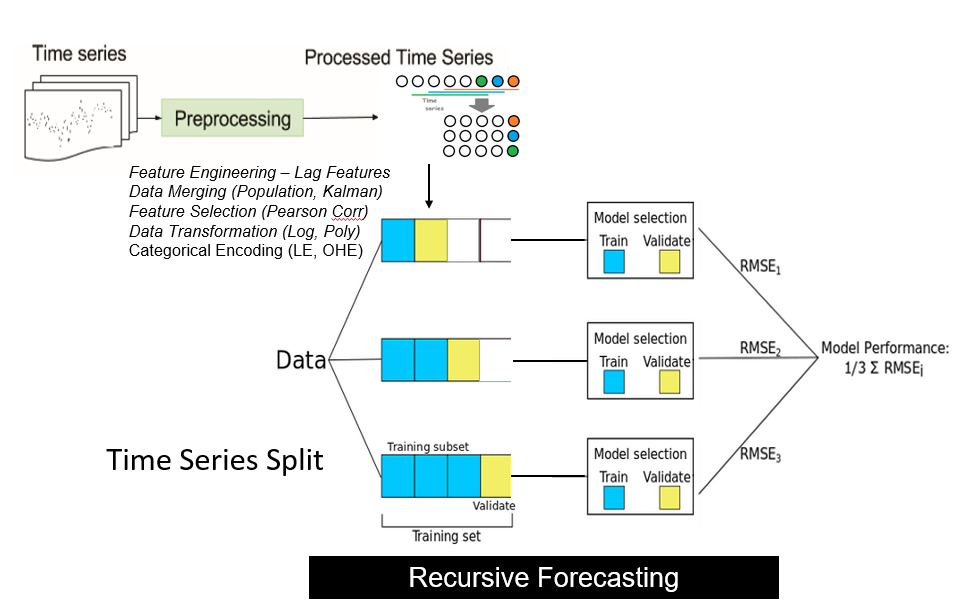

In [146]:
from IPython.display import Image
Image(filename='method.png') 

In [129]:
# Functions Definitions


# GridSearch for Random Forest
def run_gridsearch_RF(n):
    train = feat_df[feat_df['date'] < 161] # jan 22, 2020 - june 30, 2020
    xtr = train.drop(['confirmed'], axis=1)
    ytr = train['confirmed'].values
    tscv = TimeSeriesSplit(n_splits=n)
    
    # Set variables
    clf = RandomForestRegressor(n_jobs=-1, random_state=42)
    
    # Preprocess
    log_features   = ['last_day', 'Infection_rate', 'Kalman']
    preprocessing = ColumnTransformer(
        transformers=[
        ('log', FunctionTransformer(np.log1p, validate=False), log_features),
        ('ohe', OneHotEncoder(handle_unknown="ignore",), ['Region'])],
        remainder='passthrough')
    
    # Make pipeline
    pipe = Pipeline([('pre', preprocessing), ('clf', clf)])

    # Set params for Grid Search
    params = {}
    params['clf__n_estimators'] = [100, 500, 1500, 3000] # The number of trees in the forest
    params['clf__max_depth'] = [3, 6, 10] # The maximum depth of the tree
    params['clf__min_samples_split'] = [2, 10, 15] # The minimum number of samples required to split an internal node
    params['clf__min_samples_leaf'] = [1, 5, 10] # The minimum number of samples required to be at a leaf node
 
    # Run grid search
    grid = GridSearchCV(pipe, params, cv=tscv, n_jobs=-1, scoring='r2', verbose=4)
    grid.fit(xtr, ytr)

    print("Best R2 score:")
    print(grid.best_score_)
    print("Best parameters found:")
    print(grid.best_params_)

# GridSearch for boosting model GradientBoosting 
def run_gridsearch_GB(n):
    # Separate target variable from independent variables
    train = feat_df[feat_df['date'] < 161] # jan 22, 2020 - june 30, 2020
    xtr = train.drop(['confirmed'], axis=1)
    ytr = train['confirmed'].values

    # Set variables
    tscv = TimeSeriesSplit(n_splits=n)
    clf = GradientBoostingRegressor(random_state=42)
    
    # Preprocess
    log_features   = ['last_day', 'Infection_rate', 'Kalman']
    preprocessing = ColumnTransformer(
        transformers=[
        ('log', FunctionTransformer(np.log1p, validate=False), log_features),
        ('ohe', OneHotEncoder(handle_unknown="ignore",), ['Region'])],
        remainder='passthrough')
    
    # Make pipeline
    pipe = Pipeline([('pre', preprocessing), ('clf', clf)])

    # Set params for Grid Search
    params = {}
    params['clf__learning_rate'] = [0.01, 0.25, 0.05, 0.75, 1] # learning rate shrinks the contribution of each tree by learning_rate
    params['clf__n_estimators'] = [100, 500, 1500, 3000] # The number of trees in the forest
    params['clf__max_depth'] = [3, 6, 10] # The maximum depth of the tree
    params['clf__min_samples_split'] = [2, 10, 15] # The minimum number of samples required to split an internal node
    params['clf__min_samples_leaf'] = [1, 5, 10] # The minimum number of samples required to be at a leaf node
   
    # Run grid search
    grid = GridSearchCV(pipe, params, cv=tscv, n_jobs=-1, scoring='r2', verbose=4)
    grid.fit(xtr, ytr)

    print("Best R2 score:")
    print(grid.best_score_)
    print("Best parameters found:")
    print(grid.best_params_)

# GridSearch for boosting model XGBoost 
def run_gridsearch_XGB(n):
    # Separate target variable from independent variables
    train = feat_df[feat_df['date'] < 161] # jan 22, 2020 - june 30, 2020
    xtr = train.drop(['confirmed'], axis=1)
    ytr = train['confirmed'].values

    # Set variables
    tscv = TimeSeriesSplit(n_splits=n)
    clf = XGBRegressor(n_jobs=-1, random_state=42)
    
    # Preprocess
    log_features   = ['last_day', 'Infection_rate', 'Kalman']
    preprocessing = ColumnTransformer(
        transformers=[
        ('log', FunctionTransformer(np.log1p, validate=False), log_features),
        ('ohe', OneHotEncoder(handle_unknown="ignore",), ['Region'])],
        remainder='passthrough')
    
    pipe = Pipeline([('pre', preprocessing), ('clf', clf)])

    # Set params for Grid Search
    params = {}
    params['clf__learning_rate'] = [0.01, 0.25, 0.05, 0.75, 1] # learning rate shrinks the contribution of each tree by learning_rate
    params['clf__n_estimators'] = [100, 500, 1500, 3000] # The number of trees in the forest
    params['clf__max_depth'] = [3, 6, 10] # The maximum depth of the tree
    params['clf__min_child_weight'] = [1, 3, 5] # The minimum sum of weights of all observations required in a child
    params['clf__gamma'] = [0.01, 0.1, 0.2] # Gamma specifies the minimum loss reduction required to make a split
 
    # Run grid search
    grid = GridSearchCV(pipe, params, cv=tscv, n_jobs=-1, scoring='r2', verbose=4)
    grid.fit(xtr, ytr)

    print("Best R2 score:")
    print(grid.best_score_)
    print("Best parameters found:")
    print(grid.best_params_)

    
# Create Regression Score
def score_regression(ytrue, ypred, report=True):
    r2 = r2_score(ytrue, ypred)
    rmse = np.sqrt(mean_squared_error(ytrue, ypred))
    mae = mean_absolute_error(ytrue, ypred)

    report_string = "---Regression Score--- \n"
    report_string += "R2 = " + str(r2) + "\n"
    report_string += "RMSE = " + str(rmse) + "\n"
    report_string += "MAE = " + str(mae) + "\n"

    if report:
        print(report_string)

    return r2, rmse, mae

# Recursive forecasting is feeding the prediction of the model as a new input and use this to predict a new output. 
# This is “rolling” the predictions forward until the future point of interest is reached 
def recursive_forecast(input_df, preprocess_num, model):
    
    mean_r2 = []
    mean_rmse = []
    mean_mae = []

    for forecast_start_dt in range(161,192):
        train = input_df[input_df['date'] < forecast_start_dt]
        val = input_df[input_df['date'] == forecast_start_dt]

        xtr, xts = train.drop(['confirmed'], axis=1), val.drop(['confirmed'], axis=1)
        ytr, yts = train['confirmed'].values, val['confirmed'].values

        # Preprocess
        log_features   = ['last_day', 'Infection_rate', 'Kalman']
        preprocessing = ColumnTransformer(
            transformers=[
            #('log', FunctionTransformer(np.log1p, validate=False), log_features),
            ('log', preprocess_num, log_features),
            ('ohe', OneHotEncoder(), ['Region'])],
        remainder='passthrough')

        # model fit
        gb_reg = Pipeline(steps=[
        ('preprocess', preprocessing),
        ('gbr', model)
        ]).fit(xtr, ytr)

        # model predict
        pred = gb_reg.predict(xts)

        # calculate error
        r2, rmse, mae = score_regression(yts, pred, False)
        print('date {} - Error: R2 {}, RMSE {}, MAE {}'.format(forecast_start_dt, r2, rmse, mae))
        mean_r2.append(r2)
        mean_rmse.append(rmse)
        mean_mae.append(mae)

    print('Train Mean R2 = %.5f' % np.mean(mean_r2), end=', ')
    print('Train Mean RMSE = %.5f' % np.mean(mean_rmse), end=', ')
    print('Train Mean MAE = %.5f' % np.mean(mean_mae))
    
    val = input_df[feat_df['date'] >= 192]
    xts = val.drop(['confirmed'], axis=1)
    yts_df = val['confirmed'].values
    xts_df = preprocessing.transform(xts)

    return xts_df, yts_df

def get_test_df():
    val = feat_df[feat_df['date'] >= 192]
    le_dt = le.inverse_transform(val['date'])
    inv_dt = pd.DataFrame(le_dt, columns=['date_inverse']) 
    inv_dt.insert(0, 'tmp1', val['date'].tolist())
    inv_dt.insert(0, 'tmp2', val['Region'].tolist())
    df = pd.merge(inv_dt, val, left_on=['tmp1', 'tmp2'], right_on=['date','Region'])
    df.drop(['tmp1','tmp2','date'], axis=1, inplace=True)
    return df


def test_model(testx_df, testy_df, model):
    # model predict
    pred = model.predict(testx_df)

    # calculate error
    r2, rmse, mae = score_regression(testy_df, pred, False)
    print('Test: R2 = {}, RMSE = {}, MAE = {}'.format(r2, rmse, mae))
    
    # reconstruct the test dataframe wth prediction
    df = get_test_df()
    pred_df = pd.DataFrame(pred, columns=['prediction']) 
    pred_df.insert(0, 'tmp1', df['date_inverse'].tolist())
    pred_df.insert(0, 'tmp2', df['Region'].tolist())
    final_pred_df = pd.merge(pred_df, df, left_on=['tmp1', 'tmp2'], right_on=['date_inverse','Region'])
    final_pred_df.drop(['tmp1','tmp2'], axis=1, inplace=True)
    final_pred_df.prediction = final_pred_df.prediction.astype(int)
    final_pred_df['residual'] = final_pred_df['confirmed'] - final_pred_df['prediction']
    
    return final_pred_df

#### BASELINE SETTING 

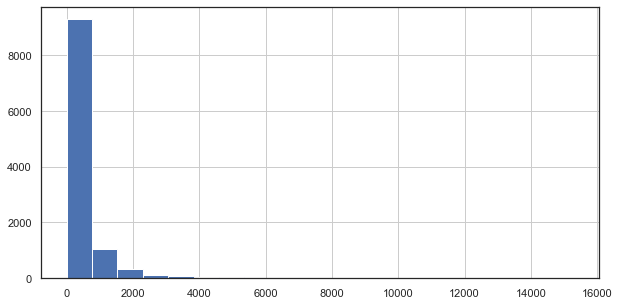

In [62]:
feat_df['confirmed'].hist(bins=20, figsize=(10,5))

From the histogram above, if we look at the distribution of number of daily confirmed cases in the dataset, we see that a lot of states has very minimal number of daily confirmed cases. So we should expect the error to look "high".

In [90]:
mean_r2 = []
mean_rmse = []
mean_mae = []

for forecast_start_dt in range(161,192):
    train = feat_df[feat_df['date'] < forecast_start_dt]
    val = feat_df[feat_df['date'] == forecast_start_dt]
    p = val['last_day'].values
    
    r2, rmse, mae = score_regression(val['confirmed'].values, p, False)
    print('date {} - Error: R2 {}, RMSE {}, MAE {}'.format(forecast_start_dt, r2, rmse, mae))
    mean_r2.append(r2)
    mean_rmse.append(rmse)
    mean_mae.append(mae)   

print('Train Mean R2 = %.5f' % np.mean(mean_r2), end=', ')
print('Train Mean RMSE = %.5f' % np.mean(mean_rmse), end=', ')
print('Train Mean MAE = %.5f' % np.mean(mean_mae))

date 161 - Error: R2 0.9317786983222075, RMSE 491.08668747522023, MAE 205.94230769230768
date 162 - Error: R2 0.880624973555911, RMSE 672.7959743316862, MAE 271.96153846153845
date 163 - Error: R2 0.878588469010053, RMSE 618.725349159308, MAE 241.51923076923077
date 164 - Error: R2 0.9185181624330426, RMSE 530.6878881370712, MAE 256.5192307692308
date 165 - Error: R2 0.53561924094915, RMSE 1457.823799630542, MAE 442.0769230769231
date 166 - Error: R2 0.49503546136726295, RMSE 1157.0474526536532, MAE 431.0
date 167 - Error: R2 0.8099867902827483, RMSE 1058.716639652425, MAE 428.34615384615387
date 168 - Error: R2 0.8655079538715488, RMSE 780.3999467728563, MAE 296.7307692307692
date 169 - Error: R2 0.9535047941217685, RMSE 508.4042153187227, MAE 223.6153846153846
date 170 - Error: R2 0.9307786252145275, RMSE 605.9908922900257, MAE 294.5769230769231
date 171 - Error: R2 0.9663159001944145, RMSE 379.4407068304612, MAE 223.48076923076923
date 172 - Error: R2 0.8910128550810861, RMSE 803.44

Now we know that our model has to have a less training error than about (RMSE) 720.

#### LINEAR REGRESSOR

In [83]:
start = time.time()
pre = FunctionTransformer(np.log1p, validate=False)
model = LinearRegression()
xts_df, yts_df = recursive_forecast(feat_df, pre, model)
lr_pred = test_model(xts_df, yts_df, model)
lr_pred
end = time.time()
print('Time elapsed:', end - start, 's') 

date 161 - Error: R2 0.3377493591032741, RMSE 1530.0631443760128, MAE 630.8025446522234
date 162 - Error: R2 0.32487933936634683, RMSE 1599.9902760185987, MAE 628.3323586086861
date 163 - Error: R2 0.3516526228164486, RMSE 1429.7885695710468, MAE 595.9504542501383
date 164 - Error: R2 0.3174799180412169, RMSE 1535.9125381522695, MAE 597.5203622939881
date 165 - Error: R2 0.30767677087345413, RMSE 1780.0097420101151, MAE 668.6824911116965
date 166 - Error: R2 0.4035024841308309, RMSE 1257.549387115779, MAE 546.0376067888118
date 167 - Error: R2 0.30398848503104225, RMSE 2026.2641195625818, MAE 739.9633613534465
date 168 - Error: R2 0.35439027476375784, RMSE 1709.8340543547247, MAE 702.8555503809862
date 169 - Error: R2 0.32810138160973656, RMSE 1932.6665462484275, MAE 759.8393871880801
date 170 - Error: R2 0.3379537067571853, RMSE 1874.0888031093723, MAE 788.7762331530823
date 171 - Error: R2 0.37464578189959974, RMSE 1634.9124073183125, MAE 729.6225833929079
date 172 - Error: R2 0.3144

In [91]:
start = time.time()
pre = PolynomialFeatures(degree=2)
model = LinearRegression()
xts_df, yts_df = recursive_forecast(feat_df, pre, model)
lr_poly_pred = test_model(xts_df, yts_df, model)
end = time.time()
print('Time elapsed:', end - start, 's') 

date 161 - Error: R2 0.9467739675854897, RMSE 433.770694287881, MAE 158.82031858997243
date 162 - Error: R2 0.967356610999476, RMSE 351.82302955048107, MAE 153.08825825371886
date 163 - Error: R2 0.9736676392314447, RMSE 288.1461623931205, MAE 122.93426598670743
date 164 - Error: R2 0.9265819862660998, RMSE 503.7442292048665, MAE 184.42234264951497
date 165 - Error: R2 0.8366374784172752, RMSE 864.6575572639177, MAE 277.4551465838683
date 166 - Error: R2 0.9358654127488547, RMSE 412.3508387270303, MAE 232.16248124686854
date 167 - Error: R2 0.8940419894917605, RMSE 790.5962306768893, MAE 291.61318576312965
date 168 - Error: R2 0.9864331799411001, RMSE 247.8608661956334, MAE 140.35728677590268
date 169 - Error: R2 0.9497802624972347, RMSE 528.3750164742116, MAE 195.28422593740922
date 170 - Error: R2 0.9901622821315125, RMSE 228.451055277527, MAE 130.16302389080423
date 171 - Error: R2 0.9855511719905529, RMSE 248.51222553267027, MAE 138.37049866538104
date 172 - Error: R2 0.98035957773

Linear regression responds well to the use of polynomial input variables as shown by the scores improvement.

#### RANDOM FOREST REGRESSOR

In [112]:
# Warning!!! This will take around 8 min using my optimized performance of 6-core processor runs two threads per core, 
# for the total of 12 logical processors running in parallel

# Running gridsearch for RandomForest with cross validation of 3 to check the optimised set of hyperparameters
start = time.time()
run_gridsearch_RF(3)
end = time.time()
print('Time elapsed:', end - start, 's') 

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  8.7min finished


Best R2 score:
0.9416191304846141
Best parameters found:
{'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 500}
Time elapsed: 525.9463663101196 s


Now, use the tuned combination of hyperparameters given by GridSearch to RandomForest

In [111]:
start = time.time()
pre = FunctionTransformer(np.log1p, validate=False)
model = RandomForestRegressor(n_estimators=500, min_samples_split=10, min_samples_leaf=1,
                              max_depth=10, n_jobs=-1, random_state=42)
xts_df, yts_df = recursive_forecast(feat_df, pre, model)
rf_pred = test_model(xts_df, yts_df, model)
end = time.time()
print('Time elapsed:', end - start, 's') 

date 161 - Error: R2 0.9470324851598371, RMSE 432.71600510290347, MAE 147.844414884886
date 162 - Error: R2 0.983749257308691, RMSE 248.23513474002493, MAE 130.92808115240402
date 163 - Error: R2 0.9217249916251284, RMSE 496.7976158880711, MAE 159.28245608259155
date 164 - Error: R2 0.9318685615100154, RMSE 485.2689991664741, MAE 168.62186063534836
date 165 - Error: R2 0.8344733178010529, RMSE 870.3660303910775, MAE 254.74935921189834
date 166 - Error: R2 0.9446317813070748, RMSE 383.13427546159573, MAE 209.82819370469684
date 167 - Error: R2 0.8856456745820218, RMSE 821.3232933811497, MAE 259.37621869801217
date 168 - Error: R2 0.9952974482745566, RMSE 145.92702252734304, MAE 90.84406746510277
date 169 - Error: R2 0.9685473161125459, RMSE 418.15174190078517, MAE 154.39527573294478
date 170 - Error: R2 0.9895140146625903, RMSE 235.8579990755873, MAE 128.95665555146658
date 171 - Error: R2 0.985566105893143, RMSE 248.3837647043993, MAE 128.79725889583523
date 172 - Error: R2 0.903933731

However, manual tuning gives me the best performance from the combination of hyperparameter below. This might be due to Recursive forecasting approach that is feeding the prediction of the model as a new input and use this to predict a new output. This is totally different approach to conventional direct forecasting which I think we can attribute to GridSearch method.

In [136]:
# Warning!!! This will take around 28 min to run using my 6-core processor machine
start = time.time()
pre = FunctionTransformer(np.log1p, validate=False)
model = RandomForestRegressor(n_estimators=3000, max_depth=None,
                              min_samples_leaf=1, min_samples_split=2,
                              n_jobs=-1, random_state=42)

xts_df, yts_df = recursive_forecast(feat_df, pre, model)
rf_pred = test_model(xts_df, yts_df, model)
end = time.time()
print('Time elapsed:', end - start, 's') 

date 161 - Error: R2 0.9414987839194434, RMSE 454.7582719223986, MAE 142.34207692307692
date 162 - Error: R2 0.9831347317871426, RMSE 252.88511659078858, MAE 124.80407692307692
date 163 - Error: R2 0.9163117733626283, RMSE 513.6888323733006, MAE 149.83192948717945
date 164 - Error: R2 0.9333785347762977, RMSE 479.8614462299638, MAE 162.2804935897436
date 165 - Error: R2 0.8406467474779438, RMSE 853.981364303123, MAE 241.90837820512817
date 166 - Error: R2 0.9429066845987569, RMSE 389.0571147950236, MAE 190.02043589743582
date 167 - Error: R2 0.8975618457496791, RMSE 777.3537789091292, MAE 237.10607692307693
date 168 - Error: R2 0.9970411347547166, RMSE 115.7528050157254, MAE 70.97629487179488
date 169 - Error: R2 0.9719825101999959, RMSE 394.6568693257284, MAE 142.7004294871795
date 170 - Error: R2 0.9914404518956805, RMSE 213.09409011056897, MAE 114.15047435897438
date 171 - Error: R2 0.9783577653081615, RMSE 304.1462730386539, MAE 134.78358974358974
date 172 - Error: R2 0.90946889791

#### GRADIENT BOOSTING REGRESSOR

In [87]:
# Warning!!! This will take around 34 min using my optimized performance of 6-core processor runs two threads per core, 
# for the total of 12 logical processors running in parallel

# Running gridsearch for Gradient Boosting with cross validation of 3 to check for the optimised set of hyperparameters
start = time.time()
run_gridsearch_GB(3)
end = time.time()
print('Time elapsed:', end - start, 's') 

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 1177 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 34.1min finished


Best R2 score:
0.9492894750573845
Best parameters found:
{'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}
Time elapsed: 2050.659239768982 s


Now, use the tuned combination of hyperparameters given by GridSearch to GradientBoosting 

In [88]:
start = time.time()
pre = FunctionTransformer(np.log1p, validate=False)
model = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,
                                  max_depth=3, min_samples_leaf=10, min_samples_split=2,
                                  random_state=42)
xts_df, yts_df = recursive_forecast(feat_df, pre, model)
gb_pred = test_model(xts_df, yts_df, model)
end = time.time()
print('Time elapsed:', end - start, 's') 

date 161 - Error: R2 0.9574230885420354, RMSE 387.9584698058768, MAE 134.74045186711606
date 162 - Error: R2 0.9927052494448467, RMSE 166.31517100162134, MAE 106.01254227515506
date 163 - Error: R2 0.9602777721071045, RMSE 353.90340488637, MAE 150.36008250910425
date 164 - Error: R2 0.9553013344533438, RMSE 393.05746369120186, MAE 139.26637925944263
date 165 - Error: R2 0.8725359560999277, RMSE 763.7685544518699, MAE 234.54570701609597
date 166 - Error: R2 0.9710928859450321, RMSE 276.83633956733655, MAE 158.34565620984296
date 167 - Error: R2 0.9305349242989284, RMSE 640.1343000627481, MAE 218.23604325203794
date 168 - Error: R2 0.9944391568561384, RMSE 158.68623390107805, MAE 99.3953766705445
date 169 - Error: R2 0.9841823384162739, RMSE 296.5351601616303, MAE 133.72793950934877
date 170 - Error: R2 0.9916073317816891, RMSE 211.00658762378643, MAE 127.27811498570091
date 171 - Error: R2 0.9911820453813501, RMSE 194.14015749956576, MAE 110.16911753614355
date 172 - Error: R2 0.9394609

Similar to Random Forest, manual tuning gives me the best performance from the combination of hyperparameter below for Gradient Boosting model. 

In [130]:
# Warning!!! This will take around 10 min to run using my 6-core processor machine
start = time.time()
pre = FunctionTransformer(np.log1p, validate=False)
model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                  max_depth=3, min_samples_leaf=1, min_samples_split=2,
                                  random_state=42)
xts_df, yts_df = recursive_forecast(feat_df, pre, model)
gb_pred = test_model(xts_df, yts_df, model)
end = time.time()
print('Time elapsed:', end - start, 's') 

date 161 - Error: R2 0.9737393671233208, RMSE 304.6847760200221, MAE 92.23168467743389
date 162 - Error: R2 0.99069493947514, RMSE 187.83920650881265, MAE 87.05295125745766
date 163 - Error: R2 0.9832996599061685, RMSE 229.4724747609762, MAE 81.14222302335108
date 164 - Error: R2 0.9719352916596131, RMSE 311.45050197479674, MAE 112.071979826936
date 165 - Error: R2 0.9243442930838855, RMSE 588.4218271893742, MAE 159.19121278019534
date 166 - Error: R2 0.9865025435212688, RMSE 189.16757569216566, MAE 98.61377581384085
date 167 - Error: R2 0.9525069696171992, RMSE 529.3010828869803, MAE 156.91148304115114
date 168 - Error: R2 0.9934831172213059, RMSE 171.78644220528471, MAE 79.9279284920618
date 169 - Error: R2 0.9846145987679522, RMSE 292.4552813217084, MAE 111.41272812849147
date 170 - Error: R2 0.9906949263949553, RMSE 222.1804761740217, MAE 114.12637387709698
date 171 - Error: R2 0.9945303588701409, RMSE 152.90118957156886, MAE 80.17492008298596
date 172 - Error: R2 0.950402453517123

#### XGBOOST REGRESSOR

In [98]:
# Warning!!! This will take around 24 min using my optimized performance of 6-core processor runs two threads per core, 
# for the total of 12 logical processors running in parallel

# Running gridsearch for XGBoost with cross validation of 3 to check for the optimised set of hyperparameters
start = time.time()
run_gridsearch_XGB(3)
end = time.time()
print('Time elapsed:', end - start, 's') 

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 589 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1177 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 24.1min finished


Best R2 score:
0.9484872668460412
Best parameters found:
{'clf__gamma': 0.01, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__min_child_weight': 3, 'clf__n_estimators': 1500}
Time elapsed: 1451.7693502902985 s


Now, use the tuned combination of hyperparameters given by GridSearch to XGBoost

In [100]:
start = time.time()
pre = FunctionTransformer(np.log1p, validate=False)
model = XGBRegressor(n_estimators=1500, learning_rate=0.01, 
                     max_depth=3, min_child_weight=3, gamma=0.01,
                     n_jobs=-1, random_state=42)

xts_df, yts_df = recursive_forecast(feat_df, pre, model)
xgb_pred = test_model(xts_df, yts_df, model)
end = time.time()
print('Time elapsed:', end - start, 's') 

date 161 - Error: R2 0.9487965205791743, RMSE 425.4493821221497, MAE 140.74301992471402
date 162 - Error: R2 0.9892330614983126, RMSE 202.05646934832993, MAE 119.3161123257417
date 163 - Error: R2 0.9580696205646457, RMSE 363.60708571100247, MAE 149.5582109460464
date 164 - Error: R2 0.9484345047142271, RMSE 422.1709690034693, MAE 150.43514855091388
date 165 - Error: R2 0.8900530285227221, RMSE 709.3483502328729, MAE 229.45999864431528
date 166 - Error: R2 0.9653296524914079, RMSE 303.17949662903595, MAE 172.81838488578796
date 167 - Error: R2 0.9232821951509552, RMSE 672.7224569862307, MAE 220.17952963595206
date 168 - Error: R2 0.9867553155705417, RMSE 244.90053746727432, MAE 113.17008227568407
date 169 - Error: R2 0.9823395730740556, RMSE 313.33265180212373, MAE 132.77368253927963
date 170 - Error: R2 0.9903760424208526, RMSE 225.9554582814375, MAE 136.85991873190954
date 171 - Error: R2 0.9912491432336934, RMSE 193.40011839107734, MAE 113.27626406229459
date 172 - Error: R2 0.93821

Similar to last two models, manual tuning gives me the best performance from the combination of hyperparameter below for XGBoost model. 

In [132]:
# Warning!!! This will take around 7 min to run using my 6-core processor machine
start = time.time()
pre = FunctionTransformer(np.log1p, validate=False)
model = XGBRegressor(n_estimators=3000, learning_rate=0.1, 
                     max_depth=6, min_child_weight=1, 
                     n_jobs=-1, random_state=42)

xts_df, yts_df = recursive_forecast(feat_df, pre, model)
xgb_pred = test_model(xts_df, yts_df, model)
end = time.time()
print('Time elapsed:', end - start, 's') 

date 161 - Error: R2 0.9546419993643408, RMSE 400.4286213543134, MAE 123.19555401802063
date 162 - Error: R2 0.9916103035921207, RMSE 178.36094578847928, MAE 85.65097610767072
date 163 - Error: R2 0.9560548851058766, RMSE 372.24017505978765, MAE 99.51005783447853
date 164 - Error: R2 0.9629856053381978, RMSE 357.67953660169854, MAE 134.13790155374087
date 165 - Error: R2 0.8483870793775582, RMSE 832.9828010464146, MAE 182.45082720426413
date 166 - Error: R2 0.9646995417150221, RMSE 305.9221353581087, MAE 135.66305869817734
date 167 - Error: R2 0.9171838272014783, RMSE 698.9488908160007, MAE 193.53781591928922
date 168 - Error: R2 0.997672873234139, RMSE 102.65472675035511, MAE 60.51289332371492
date 169 - Error: R2 0.9754421706721756, RMSE 369.48774934582156, MAE 110.2501759162316
date 170 - Error: R2 0.9948779943398363, RMSE 164.84129352571125, MAE 78.88671461435464
date 171 - Error: R2 0.9828890314719175, RMSE 270.4386405622614, MAE 114.02287382345934
date 172 - Error: R2 0.938029102

### COVID19 FORECASTING

In [139]:
# Defined functions

import datetime
sns.set(rc={'figure.figsize':(11, 4)})

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Date")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def merge_models_predictions(state):
    # Merge different ML models predictions
    xgb_df = xgb_pred[xgb_pred['Region']==state][['prediction', 'date_inverse', 'Region', 'Kalman', 'confirmed', 'residual']]
    gbr_df = gb_pred[gb_pred['Region']==state][['prediction', 'date_inverse', 'Region', 'residual']]
    merge1_df = pd.merge(xgb_df, gbr_df, left_on=['date_inverse', 'Region'], right_on=['date_inverse', 'Region'])
    merge1_df.rename(columns = {'prediction_x':'xgb_prediction', 
                                'residual_x':'xgb_residual',
                                'prediction_y':'gbr_prediction', 
                                'residual_y':'gbr_residual',
                               }, inplace = True) 
    rf_df = rf_pred[rf_pred['Region']==state][['prediction', 'date_inverse', 'Region', 'residual']]
    lr_poly_df = lr_poly_pred[lr_poly_pred['Region']==state][['prediction', 'date_inverse', 'Region', 'residual']]
    merge2_df = pd.merge(rf_df, lr_poly_df, left_on=['date_inverse', 'Region'], right_on=['date_inverse', 'Region'])
    merge2_df.rename(columns = {'prediction_x':'rf_prediction', 
                                'residual_x':'rf_residual',
                                'prediction_y':'lr_poly_prediction', 
                                'residual_y':'lr_poly_residual',
                               }, inplace = True) 
    merge_final_df = pd.merge(merge1_df, merge2_df, left_on=['date_inverse', 'Region'], right_on=['date_inverse', 'Region'])
    return merge_final_df

def plot_forecast(state):
    # Plot ML models predictions
    df = merge_models_predictions(state)
    plt.scatter(df.date_inverse, df.confirmed, label = 'Actual Test Value')
    #plot_series(merge_final_df.date_inverse, merge_final_df.Kalman, label = 'Kalman')
    plot_series(df.date_inverse, df.xgb_prediction, label = 'XGBoost')
    plot_series(df.date_inverse, df.gbr_prediction, label= 'GradientBoost')
    plot_series(df.date_inverse, df.rf_prediction, label = 'RandomForest')
    plot_series(df.date_inverse, df.lr_poly_prediction, label = 'LinearRegression(Poly)')
    plt.title('COVID19 Confirmed Cases Forecasting - Aug 01 to 22 (' + state + ')')
    plt.ylabel('Daily Confirmed Cases')
    plt.legend()
    axes = plt.gca()
    axes.set_xlim([datetime.date(2020, 8, 1), datetime.date(2020, 8, 22)])

def plot_residual(state):
    # Plot Residuals
    df = merge_models_predictions(state)
    plot_series(df.date_inverse, df.xgb_residual, label = 'XGBoost')
    plot_series(df.date_inverse, df.gbr_residual, label= 'GradientBoost')
    plot_series(df.date_inverse, df.rf_residual, label = 'RandomForest')
    plot_series(df.date_inverse, df.lr_poly_residual, label = 'LinearRegression(Poly)')
    plt.title('Residual Plot - Aug 01 to 22 (' + state + ')')
    plt.ylabel('Residuals')
    plt.legend()
    axes = plt.gca()
    axes.set_xlim([datetime.date(2020, 8, 1), datetime.date(2020, 8, 22)])

#### FLORIDA

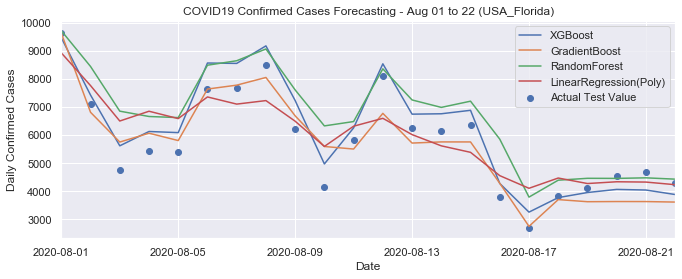

In [140]:
plot_forecast('USA_Florida')

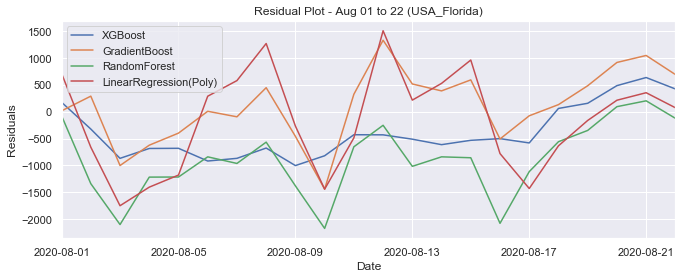

In [141]:
plot_residual('USA_Florida')

#### TEXAS

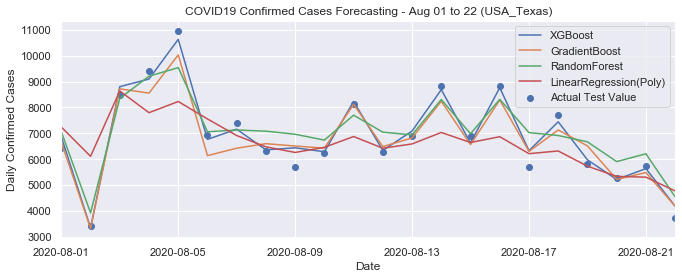

In [142]:
plot_forecast('USA_Texas')

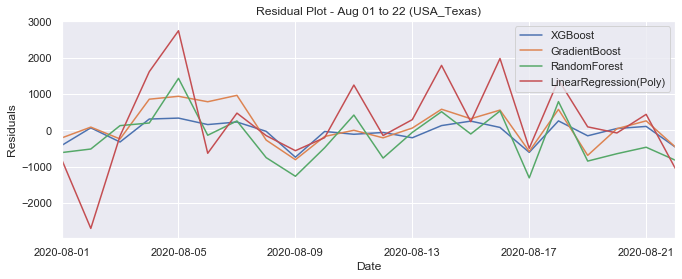

In [143]:
plot_residual('USA_Texas')

#### CALIFORNIA

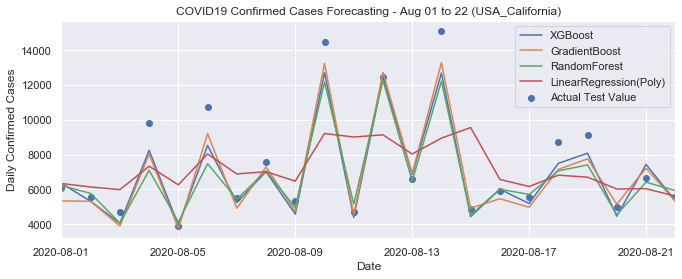

In [144]:
plot_forecast('USA_California')

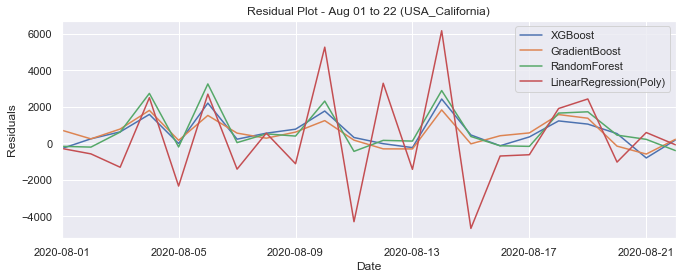

In [145]:
plot_residual('USA_California')

### RESULTS AND DISCUSSION

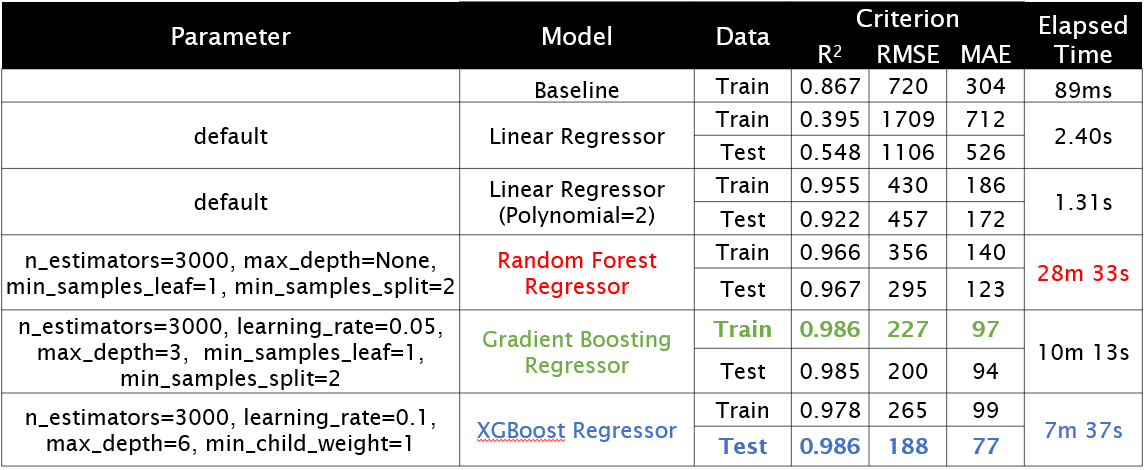

In [147]:
from IPython.display import Image
Image(filename='result.png')

### RESULTS AND DISCUSSION

From the plots above, blue dots data is the actual data and the line plots are forecasting done by different models using the test set. It is consistent that the boosting technique such as Gradient Boosting and XGBoost predicted values of COVID19 daily confirmed cases were in a good agreement with their related actual values. The residual plot also showed that the performance of XGBoost outperformed the other 3 models. 

From the result table above, it is worth to note the significant impact of feature engineering polynomial degree 2 to Linear Regressor model performance. It is shown that adding polynomial terms to the model can be an effective way of allowing the model to identify nonlinear patterns. Also, LinearRegressor without feature engineering of polynomial has the worst performance among the models, worse than the baseline. This can be explained by the COVID19 data itself which is nonlinear. 

Furthermore, it is not undisclosed that small learning rate requires more trees in the ensemble methods in order for the predictions to generalize better. However, even though Gradient Boosting algorithm has smaller learning rate than XGBoost with both models having large amount of trees, XGBoost has performed well in generalization than Gradient Boosting. In fact, XGBoost has the best results among the models while showing its capability to do parallel processing as it clocked the fastest elapsed time. On the other hand, Gradient Boosting outperformed all the models in training dataset.

### CONCLUSION AND FUTURE WORKS

Estimated values of COVID19 daily confirmed cases were in good agreement with their related observed values and the used machine learning models, especially the ensemble method – Boosting models, could be used to forecast daily confirmed cases. The good performance of boosting methods such as Gradient Boosting and XGBoost can be attributed to its technique itself where it corrects the residual error from the previous predictor instead of putting on the weights. Furthermore, these results are very worthwhile for the decision-making bodies or public health experts given that the decision with regards to this pandemic is urgent.

Moreover, the researcher has shown that approach which turning time series problem into a typical supervised learning problem is quite effective. The researcher was able to train a single machine learning model to forecast multiple time series at the same time with high R-squared, a statistical measure of how close the data are to the fitted regression. 

The researcher plan to merge more domain-related data like temperature, lockdown periods, etc, that have significant impacts in variation of number of COVID19 cases. In addition for future works, the researcher would like to explore the direct forecasting approach and learn the trade-offs between recursive forecasting and direct forecasting. This has been tackled to PhD thesis of Souhaib Ben Taieb from University of Mons, Belgium

### LIMITATIONS

The method does not include different control measures for each state such as level of social distancing and how these will change in the future. Hence, projections assume that current interventions will not change during the forecasted period. In addition, ample historical data is needed in forecasting. Currently, the data used for this study is restricted to a particular country and within the time frame of January-July 2020 to highlight the COVID-19 pandemic. The area of the analysis could be extended by adding data from other countries. This will show how the outbreak is transferred to different regions and which region is more likely to transmit the disease next. In this study, the available period of time is about half a year while considering around 50 US states which will result to approximately 11,000 data points; a relatively small data set.  

The researcher uses a pure data-driven approach by letting the machine do the learning. Despite focusing on US, the study does not include mapping of the virus' trend to specific areas or regions in the country. However, if this data is available, it would prove to be more effective because specific areas in the country, that is susceptible to the virus, can be focused on rather than just simply focusing on the timeframe.

### REFERENCES
[1] Wu JT., Leung K., Bushman M., et al. Estimating clinical severity of COVID-19 from the transmission dynamics in Wuhan, China. Nat Med. 2020; (published online March 19.)
DOI:10.1038/s41591-020-0822-7.

[2] Nicola M., Alsafi Z., Sohrabi C., Kerwan A., Al-Jabir A., Iosifidis C.…Agha R. The socio-economic implications of the coronavirus and COVID-19 pandemic: A review. Int. J. Surg. 2020;78:185–193.

[3] Dong E, Du H, Gardner L. An interactive web-based dashboard to track COVID-19 in real time. Lancet Infect Dis
2020; 20 (5): 533–4. Available: https://coronavirus.jhu.edu/map.html. [Accessed 14 July 2020].

[4] John Hopkins University, "COVID-19 Map FAQs," John Hopkins University, 30 March 2020. [Online]. Available: https://systems.jhu.edu/research/public-health/2019-ncov-map-faqs/. [Accessed 14 July 2020].

[5] Lauer S., Grantz K., Bi Q., et al. The Incubation Period of Coronavirus Disease 2019 (COVID-19) From Publicly Reported Confirmed Cases: Estimation and Application. Ann Intern Med 2020;172:577-582. 